# Tutorial: Sparse logistic regression

This tutorial demonstrates modeling and running inference on a sparse logistic regression model in Bean Machine. This tutorial showcases the inference techniques in Bean Machine, and applies the model to a public dataset to evaluate performance. This tutorial will also introduce the `@bm.functional` decorator, which can be used to deterministically transform random variables. This tutorial uses it for convenient post-processing.

## Problem

Logistic regression is a commonly used statistical method that allows us to predict a binary output from a set of independent variables. Suppose we have some prior knowledge about the data generated from the logistic regression model. We can sample the logistic regression model from the prior. The sparse logistic regression is a type of logistic regression model which embeds feature selection in classification by adding overall and per-dimension scale factors. It is very applicable when dealing with high-dimensional data, such as classifying credit scores.

Sparse logistic regression is a hierarchical model with a sparse prior. This prior is used to encourage shrinkage in the model predictions and, hopefully, prevent overfitting to the data.

## Prerequisites

Please import the following code packages for the rest of the code in the tutorial to work.

In [1]:
import beanmachine.ppl as bm

import torch
from torch import tensor
import torch.distributions as dist
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection
import logging
import io
import zlib

plt.rc('axes', xmargin=0, ymargin=0)
plt.rc('figure', figsize=[8, 6])
plt.rc('font', size=14)
plt.rc('hist', bins=30)
plt.rc('lines', linewidth=2.5)

np.set_printoptions(precision=3)
pd.set_option('precision', 3)

logging.getLogger("beanmachine").setLevel(50)
torch.manual_seed(17);

## Model

We have the following definitions.

  * $N$: Size of the dataset.
  * $D$: Number of features of the dataset.
  * $\tau$: Global shrinkage of the model.
  * $\beta_d$: Coefficient corresponding to dimension $d \in D$.
  * $\lambda_d$: Local shrinkage for the coefficient corresponding to dimension $d \in D$.
  * $\alpha$, $\beta$: Hyperparameters controlling the shape and strength of $\tau$ and each $\lambda_d$.

The model is defined mathematically as follows:

  * $\tau \sim \text{Gamma}(\alpha, \beta)$
  * $\lambda_d \stackrel{iid}{\sim} \text{Gamma}(\alpha, \beta)$
  * $\beta_d \stackrel{iid}{\sim} \mathcal{N}(0, 1)$
  * $y_n \stackrel{iid}{\sim} \text{Bernoulli}(\sigma({X}^\textsf{T}(\tau\beta \circ \lambda)))$

A few notes:

  * $\sigma(s) = \frac{1}{1 + e^{ -s } }$ is the logistic function. Its purpose is to translate an unconstrained score $s \in (-\infty, \infty)$ predicted by the model into a probability $\sigma(s) \in (0, 1)$.
  * $\beta \circ \lambda$ denotes the elementwise product of $\beta$ and $\lambda$.
  * As we'll see right below, $\tau$ and $\lambda_d$ tend toward small values. Thus, $\lambda_d$ tends to shrink the influence of $\beta_d$, and $\tau$ tends to shrink the overall model prediction.

For purposes of this tutorial, we choose $\alpha = \beta = 0.5$.

In [2]:
alpha_hyperparam = 0.5
beta_hyperparam = 0.5

Thus, the prior for $\tau$ and each $\lambda_d$ looks like:

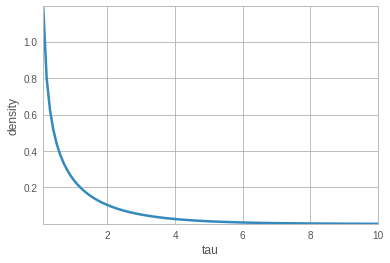

In [3]:
taus = torch.linspace(0, 10, 100)
plt.plot(taus, dist.Gamma(concentration=alpha_hyperparam, rate=beta_hyperparam).log_prob(taus).exp())
plt.xlabel("tau")
plt.ylabel("density");

We can implement this model in Bean Machine by defining random variable objects with the `@bm.random_variable` decorator. These functions behave differently than ordinary Python functions.

<div style="background: #daeaf3; border-left: 3px solid #2980b9; display: block; margin: 16px 0; padding: 12px;">
  Semantics for <code>@bm.random_variable</code> functions:
  <ul>
    <li>They must return PyTorch <code>Distribution</code> objects.
    <li>Though they return distributions, callees actually receive <i>samples</i> from the distribution. The machinery for obtaining samples from distributions is handled internally by Bean Machine.
    <li>Inference runs the model through many iterations. During a particular inference iteration, a distinct random variable will correspond to exactly one sampled value: <b>calls to the same random variable function with the same arguments will receive the same sampled value within one inference iteration</b>. This makes it easy for multiple components of your model to refer to the same logical random variable.
    <li>Consequently, to define distinct random variables that correspond to different sampled values during a particular inference iteration, an effective practice is to add a dummy "indexing" parameter to the function. Distinct random variables can be referred to with different values for this index.
    <li>Please see the documentation for more information about this decorator.
  </ul>
</div>

To implement sparse logistic regression model in Bean Machine, we provide `@bm.random_variable` definitions for $\tau$, $\lambda$, $\beta$, and $y$.

This is all you have to do to define the model. However, we'll also make use of the `@bm.functional` decorator to make it very easy to compute log likelihood on test data during infernece. This decorator has the same semantics as `@bm.random_variable`, except that it does not return a distribution. Instead, it returns a deterministically-computed function from other random variables. It can be used to conveniently compute values that would typically be computed in a post-processing pass. Here, we use it to compute the log probability of test data, using inferences made on training data.

In [4]:
class SparseLogisticRegression(object):
    
    def __init__(self, X_train, X_test, Y_test):
        super().__init__()
        self.X_train = X_train
        self.X_test = X_test
        self.Y_test = Y_test

    @bm.random_variable
    def tau(self):
        return dist.Gamma(alpha_hyperparam, beta_hyperparam)

    @bm.random_variable
    def lambda_(self):
        return dist.Gamma(alpha_hyperparam, beta_hyperparam).expand([self.X_train.shape[1], 1])

    @bm.random_variable
    def beta(self):
        return dist.Normal(0, 1).expand([self.X_train.shape[1], 1])

    @bm.random_variable
    def y(self):
        return dist.Bernoulli(
            logits=self.X_train @ (self.tau() * self.beta() * self.lambda_())
        )

    @bm.functional
    def log_prob_test(self):
        return dist.Bernoulli(
            logits=self.X_test @ (self.tau() * self.beta() * self.lambda_())
        ).log_prob(self.Y_test).sum()
    
    def __repr__(self):
        return f"SparseLogisticRegression with {self.X_train.shape[1]} covariates"

## Data

With the model defined, we need to collect some observed data in order to learn about values of interest in our model. For this tutorial, we'll use 1,000 two-dimensional datapoints, so that we can visualize what's going on.

We will generate a dataset where items have true label 0 and true label 1. For demonstrative purposes, we will use a synthetically generated dataset of observed values. In practice, you would gather real data and classify results by-hand, for example using human labelers.

In [5]:
X = dist.Normal(0, 5).expand([1000, 2]).sample()

true_tau = dist.Gamma(alpha_hyperparam, beta_hyperparam).sample()
true_lambda = dist.Gamma(alpha_hyperparam, beta_hyperparam).expand([X.shape[1], 1]).sample()
true_beta = dist.Normal(0, 1).expand([X.shape[1], 1]).sample()

Y = dist.Bernoulli(logits=X @ (true_tau * true_beta * true_lambda)).sample()

Let's take a moment to visualize our dataset.

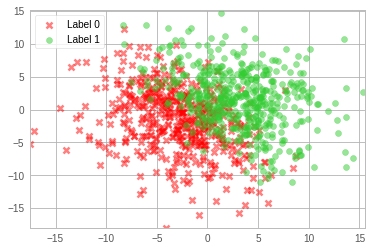

In [6]:
plt.scatter(
    X[Y[:, 0] == 0, 0],
    X[Y[:, 0] == 0, 1],
    label="Label 0",
    color="red",
    marker="x",
    alpha=0.5,
)
plt.scatter(
    X[Y[:, 0] == 1, 0],
    X[Y[:, 0] == 1, 1],
    label="Label 1",
    color="limegreen",
    marker="o",
    alpha=0.5,
)
plt.legend();

Now, we will split the dataset into a training set and a test set.

In [7]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y)

Now that we've got our data defined, we can instantiate an instance of the model.

In [8]:
model = SparseLogisticRegression(X_train, X_test, Y_test)

Our inference algorithms expect observations in the form of a dictionary. This dictionary should consist of `@bm.random_variable` invocations as keys, and tensor data as values. In order to bind this data, first we'll instantiate the model.

In [9]:
observations = { model.y(): Y_train }

## Inference

Inference is the process of combining _model_ with _data_ to obtain _insights_, in the form of probability distributions over values of interest. Bean Machine offers a powerful and general inference framework to enable fitting arbitrary models to data.

Since this model is comprised entirely of differentiable random variables, we'll make use of the Newtonian Monte Carlo (NMC) inference method. NMC is a second-order method, which uses the Hessian to automatically scale the step size in each dimension.

Running inference consists of a few arguments:

| Name | Usage
| --- | ---
| `queries` | A list of `@bm.random_variable` targets to fit posterior distributions for.
| `observations` | The `Dict` of observations we built up, above.
| `num_samples` | Number of samples to build up distributions for the values listed in `queries`.
| `num_chains` | Number of separate inference runs to use. Multiple chains can verify inference ran correctly.

Let's run inference:

In [10]:
samples = bm.SingleSiteNewtonianMonteCarlo().infer(
    queries=[
        model.tau(),
        model.lambda_(),
        model.beta(),
        model.log_prob_test(),
    ],
    observations=observations,
    num_samples=1000,
    num_chains=4,
)

Samples collected: 100%|██████████| 1000/1000 [00:40<00:00, 24.69it/s]


## Analysis

`samples` now contains our inference results.

First, we'll just print previews of the results. This should give a sense of how to work with the `samples` object, and also an idea of the shapes of the inferred values.

In [11]:
tau_marginal = samples[ model.tau() ].flatten(start_dim=0, end_dim=1).detach()
lambda_marginal = samples[ model.lambda_() ].flatten(start_dim=0, end_dim=1).detach()
beta_marginal = samples[ model.beta() ].flatten(start_dim=0, end_dim=1).detach()
log_prob_test_results = samples[ model.log_prob_test() ][0].detach()

print(
    f"tau_marginal:\n{tau_marginal}\n\n"
    f"lambda_marginal:\n{lambda_marginal}\n\n"
    f"beta_marginal:\n{beta_marginal}\n\n"
    f"log_prob_test_results:\n{log_prob_test_results[:20]}"
)

tau_marginal:
tensor([0.0108, 0.0329, 0.0329,  ..., 0.7055, 0.7420, 0.7581])

lambda_marginal:
tensor([[[0.0983],
         [0.0356]],

        [[0.0983],
         [0.0356]],

        [[0.0983],
         [0.0356]],

        ...,

        [[1.6155],
         [1.7452]],

        [[1.5987],
         [1.8116]],

        [[1.7165],
         [1.7972]]])

beta_marginal:
tensor([[[0.0000],
         [0.0000]],

        [[3.6285],
         [0.8170]],

        [[3.0866],
         [0.9251]],

        ...,

        [[0.5031],
         [0.3085]],

        [[0.4741],
         [0.2905]],

        [[0.4574],
         [0.2646]]])

log_prob_test_results:
tensor([-173.2868, -168.6548, -169.2710, -111.8275, -103.5881, -100.3477,
         -95.0384,  -95.0377,  -95.6687,  -95.0476,  -95.0453,  -90.1975,
         -90.1395,  -90.0918,  -87.2238,  -88.9762,  -88.9762,  -88.5185,
         -85.4008,  -85.6083])


Next, let's visualize the inferred random variables.

In [12]:
def plot_marginal(marginal_samples, variable_name, true_value=None):
    
    marginal_samples = marginal_samples.squeeze()

    if len(marginal_samples.shape) == 1:
        plt.title(f"{variable_name} marginal")
        plt.hist(marginal_samples, density=True)
        if true_value:
            plt.axvline(x=true_value, label="True value", color="k")
        plt.axvline(x=marginal_samples.mean(), label="Posterior mean", color="c")
        plt.xlabel(variable_name)
        plt.ylabel("density")
        plt.legend()
    
    elif len(marginal_samples.shape) == 2 and marginal_samples.shape[1] == 2:
        plt.suptitle(f"{variable_name} marginal", fontsize=20)
        
        grid = mpl.gridspec.GridSpec(4, 4)

        plt.subplot(grid[1:, :3])
        plt.hist2d(*marginal_samples.T.tolist(), bins=60, density=True)
        if true_value is not None:
            plt.plot(*true_value, "wo", label="True value")
        plt.plot(*marginal_samples.mean(dim=0), "co", label="Posterior marginal mean")
        plt.xlabel(f"{variable_name}[0]")
        plt.ylabel(f"{variable_name}[1]")
        plt.legend()

        plt.subplot(grid[0, :3])
        plt.hist(marginal_samples[:, 0], density=True)
        if true_value is not None:
            plt.axvline(true_value[0], color="k")
        plt.axvline(marginal_samples[:, 0].mean(), color="c")
        plt.ylabel("density")
        plt.gca().axes.get_xaxis().set_ticklabels([])
        plt.margins(0)

        plt.subplot(grid[1:, 3])
        plt.hist(marginal_samples[:, 1], density=True, orientation="horizontal")
        if true_value is not None:
            plt.axhline(true_value[1], color="k")
        plt.axhline(marginal_samples[:, 1].mean(), color="c")
        plt.xlabel("density")
        plt.gca().axes.get_yaxis().set_ticklabels([])
        plt.margins(0)
        
    else:
        raise Exception(
            f"Excepted: marginal_samples with shape [:] or [:, 2, :].\n"
            f"Received: marginal_samples with shape {marginal_samples.shape}."
        )
        
    plt.show()

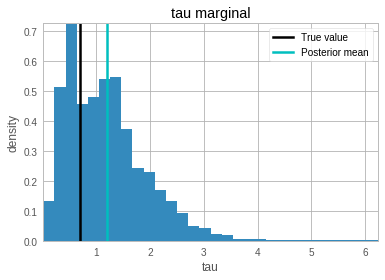

In [13]:
plot_marginal(tau_marginal, "tau", true_tau)

It looks like we've exactly recovered $\tau$.

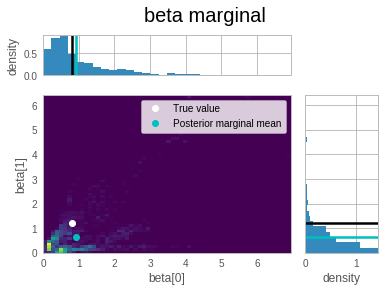

In [14]:
plot_marginal(beta_marginal, "beta", true_beta)

The marginals for $\beta$ seem reasonable, but the joint distribution attenuates to zero quite a bit more than expected. This might be a relfection of the single-site inference that Bean Machine employs by default.

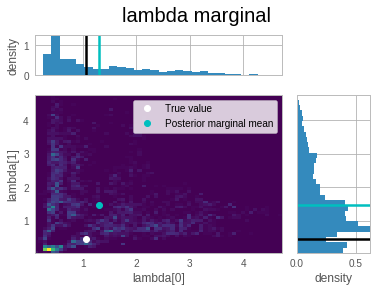

In [15]:
plot_marginal(lambda_marginal, "lambda", true_lambda)

The maringals for $\lambda$ look great. The joint also looks reasonable, given the spread of the distribution.

Lastly, let's plot the first thousand log probabilities on test data that we generated per-iteration during inference. We'll also overlay the log probability that the test datast would score on the ground truth parameters.

In [16]:
def plot_log_prob(log_prob_results, ground_truth_log_prob=None):
    plt.figure(figsize=(20, 6))
    plt.plot(log_prob_results)
    if ground_truth_log_prob:
        plt.axhline(
            ground_truth_log_prob,
            label=f"Using true params = {ground_truth_log_prob :.2f}",
            color="k",
        )
        plt.legend()
    plt.ylabel("Log probability")
    plt.margins(0.02)
    plt.show()

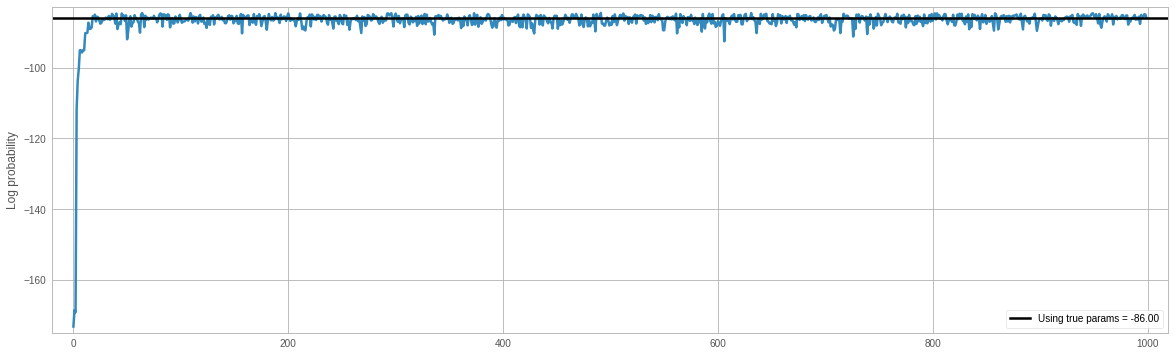

In [17]:
plot_log_prob(
    log_prob_test_results,
    dist.Bernoulli(
        logits=X_test @ (true_tau * true_beta * true_lambda)
    ).log_prob(Y_test).sum(),
)

As we can see, the model seems to have _very_ quickly converged, and it converged to parameters that correctly predicted the test dataset.

Bean Machine provides a Diagnostics package that provides helpful statistics about the results of inference. We can query this information as follows:

In [18]:
bm.Diagnostics(samples).summary()

,avg,std,2.5%,50%,97.5%,r_hat,n_eff
"beta(SparseLogisticRegression with 2 covariates,)[0, 0]",0.926,0.830,0.123,0.626,3.117,1.447,4.121
"beta(SparseLogisticRegression with 2 covariates,)[1, 0]",0.655,0.858,0.051,0.378,3.183,1.220,11.581
"lambda_(SparseLogisticRegression with 2 covariates,)[0, 0]",1.292,0.952,0.309,0.898,3.496,2.072,2.714
"lambda_(SparseLogisticRegression with 2 covariates,)[1, 0]",1.460,1.022,0.131,1.217,3.932,1.461,4.098
"log_prob_test(SparseLogisticRegression with 2 covariates,)[]",-86.462,2.675,-89.421,-86.168,-84.688,1.004,784.205
"tau(SparseLogisticRegression with 2 covariates,)[]",1.190,0.763,0.168,1.089,2.944,1.199,14.580


The summary above includes useful statisics about each marginal distribution.

The summary output also shows two diagnostic statistics: [$\hat{R}$](https://projecteuclid.org/euclid.ss/1177011136) (`r_hat`) and [$N_\text{eff}$](https://www.mcmchandbook.net/HandbookChapter1.pdf) (effective sample size, `n_eff`).

  * $\hat{R} \in [1, \infty)$ summarizes how effective inference was at converging on the correct posterior distribution for a particular random variable. It uses information from all chains run in order to assess whether inference had a good understanding of the distribution or not. Values very close to zero indicate that all chains discovered similar distributions for a particular random variable. We do not recommend using inference results where $\hat{R} > 1.1$, as inference may not have converged. In that case, you may want to run inference for more samples.
  * $N_\text{eff} \in [1, \texttt{num}\_\texttt{samples}]$ summarizes how independent posterior samples are from one another. Although inference was run for `num_samples` iterations, it's possible that those samples were very similar to each other (due to the way inference is implemented), and may not each be representative of the full posterior space. Larger numbers are better here, and if your particular use case calls for a certain number of samples to be considered, you should ensure that $N_\text{eff}$ is at least that large.
  
In this case, $\hat{R}$ seems to have generally acceptable values. It is on the high end for $\lambda$, which is in-line with teh spread of the marginals that we saw previously. $N_\text{eff}$ is on the lower end, so it may be desirable to run inference for longer.

For comparison, let's check out the model's performance using a couple of different inference methods.

## Single-site Metropolis-Hastings

Let's retry this problem, using ancestral Metropolis-Hastings as the inference algorithm to compare performance.

Ancestral Metropolis-Hastings is a simple inference algorithm, which proposes child random variables conditional on values for the parent random variables. The most ancestral random variables are simply sampled from the prior distribution.

In [19]:
samples_mh = bm.SingleSiteAncestralMetropolisHastings().infer(
    queries=[
        model.tau(),
        model.lambda_(),
        model.beta(),
        model.log_prob_test(),
    ],
    observations=observations,
    num_samples=1000,
    num_chains=4,
)

Samples collected: 100%|██████████| 1000/1000 [00:39<00:00, 25.45it/s]


In [20]:
tau_marginal = samples_mh[ model.tau() ].flatten(start_dim=0, end_dim=1).detach()
lambda_marginal = samples_mh[ model.lambda_() ].flatten(start_dim=0, end_dim=1).detach()
beta_marginal = samples_mh[ model.beta() ].flatten(start_dim=0, end_dim=1).detach()
log_prob_test_results = samples_mh[ model.log_prob_test() ].flatten(start_dim=0, end_dim=1).detach()

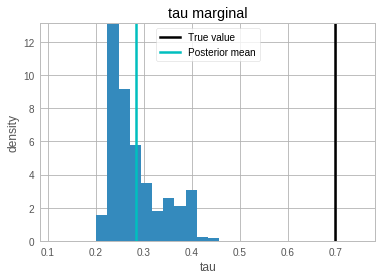

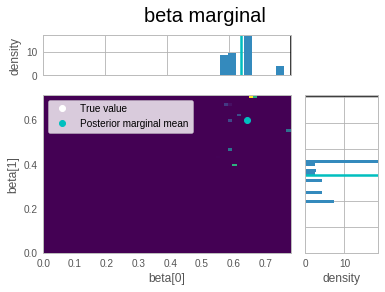

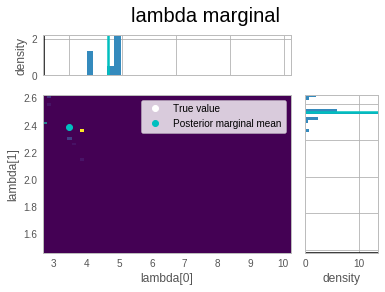

In [21]:
plot_marginal(tau_marginal, "tau", true_tau)
plot_marginal(beta_marginal, "beta", true_beta)
plot_marginal(lambda_marginal, "lambda", true_lambda)

From all of the above plots, we see that ancestral Metropolis-Hastings does a significantly worse job at recovering the true parameters! Not only do regions of uncertainty tend to _exclude_ the true values, the samples that are actually drawn are very sparse. This means that the algorithm is achieving a very poor representation of the posterior surface.

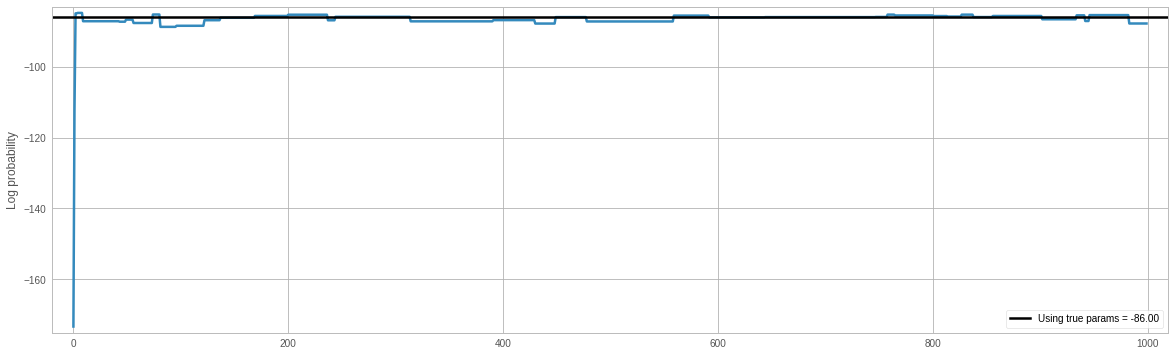

In [22]:
plot_log_prob(
    log_prob_test_results[:1000],
    dist.Bernoulli(
        logits=X_test @ (true_tau * true_beta * true_lambda)
    ).log_prob(Y_test).sum()
)

Surprisingly, the algorithm does eventually discover -- and settle in on -- parameters that seem to descirbe the test data well.

In [23]:
bm.Diagnostics(samples_mh).summary()

,avg,std,2.5%,50%,97.5%,r_hat,n_eff
"beta(SparseLogisticRegression with 2 covariates,)[0, 0]",0.641,0.056,0.574,0.650,0.779,1.261,16.615
"beta(SparseLogisticRegression with 2 covariates,)[1, 0]",0.600,0.122,0.394,0.625,0.713,3.164,3.182
"lambda_(SparseLogisticRegression with 2 covariates,)[0, 0]",3.460,0.537,2.672,3.889,3.889,3.666,2.409
"lambda_(SparseLogisticRegression with 2 covariates,)[1, 0]",2.382,0.092,2.155,2.353,2.623,1.543,11.224
"log_prob_test(SparseLogisticRegression with 2 covariates,)[]",-86.249,1.845,-88.991,-85.991,-84.603,1.065,70.318
"tau(SparseLogisticRegression with 2 covariates,)[]",0.284,0.054,0.221,0.262,0.407,2.024,3.383


$\hat{R}$ values are extremely far from 1.0. Further, the $N_\text{eff}$ values for our sampled random variables are extremely small. As a result, these inference results would be unusable for any real application.

In comparison, Newtonian Monte Carlo seems to have developed a much more complete representation of the posterior surface. For one final comparison, let's take a look at Hamiltonian Monte Carlo.

## Hamiltonian Monte Carlo

Hamiltonian Monte Carlo is a classic gradient-based inference method. HMC proceeds by taking a sequence of steps towards the gradient, but with some injected noise, before proposing a candidate sample. Bean Machine provides a single-site implementation of HMC that we can use to fit this problem. Check out our documentation for more information on HMC.

In [24]:
samples_hmc = bm.SingleSiteHamiltonianMonteCarlo(path_length=1, step_size=0.05).infer(
        queries=[
        model.tau(),
        model.lambda_(),
        model.beta(),
        model.log_prob_test(),
    ],
    observations=observations,
    num_samples=1000,
    num_chains=4,
)

Samples collected: 100%|██████████| 1000/1000 [01:59<00:00,  8.37it/s]


In [25]:
tau_marginal = samples_hmc[ model.tau() ].flatten(start_dim=0, end_dim=1).detach()
lambda_marginal = samples_hmc[ model.lambda_() ].flatten(start_dim=0, end_dim=1).detach()
beta_marginal = samples_hmc[ model.beta() ].flatten(start_dim=0, end_dim=1).detach()
log_prob_test_results = samples_hmc[ model.log_prob_test() ].flatten(start_dim=0, end_dim=1).detach()

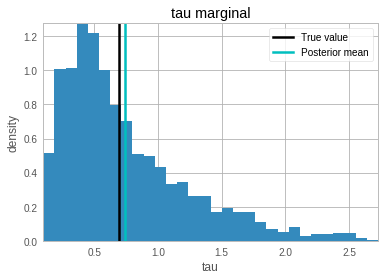

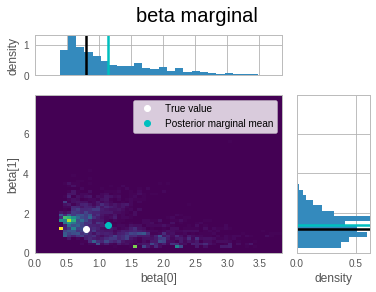

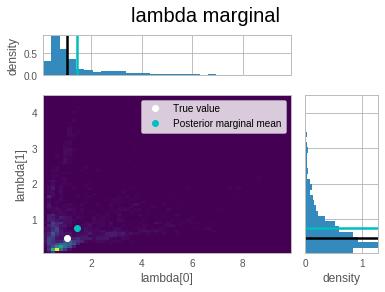

In [26]:
plot_marginal(tau_marginal, "tau", true_tau)
plot_marginal(beta_marginal, "beta", true_beta)
plot_marginal(lambda_marginal, "lambda", true_lambda)

Hamiltonian Monte Carlo seems to do a reasonably good job of recovering $\tau$ and $\beta$, and struggles with $\lambda$. The uncertainty surface is quite smooth, indicating a good coverage of the posterior surface.

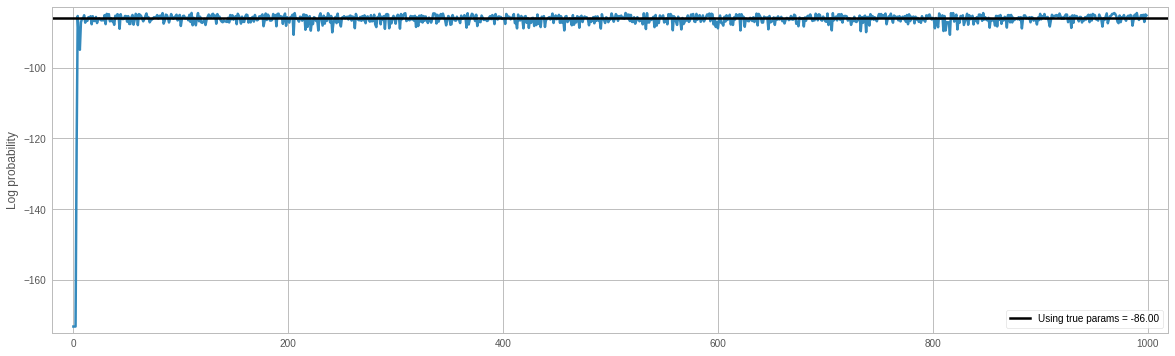

In [27]:
plot_log_prob(
    log_prob_test_results[:1000],
    dist.Bernoulli(
        logits=X_test @ (true_tau * true_beta * true_lambda)
    ).log_prob(Y_test).sum()
)

Unsurprisingly, HMC is successful in converging to the correct log probability for the test data.

In [28]:
bm.Diagnostics(samples_hmc).summary()

,avg,std,2.5%,50%,97.5%,r_hat,n_eff
"beta(SparseLogisticRegression with 2 covariates,)[0, 0]",1.144,0.664,0.423,0.915,2.790,1.627,11.470
"beta(SparseLogisticRegression with 2 covariates,)[1, 0]",1.377,0.684,0.354,1.300,2.857,1.491,14.993
"lambda_(SparseLogisticRegression with 2 covariates,)[0, 0]",1.445,1.430,0.304,0.896,5.651,1.333,16.620
"lambda_(SparseLogisticRegression with 2 covariates,)[1, 0]",0.757,0.689,0.128,0.551,2.887,1.325,10.689
"log_prob_test(SparseLogisticRegression with 2 covariates,)[]",-86.264,2.690,-88.821,-85.997,-84.617,1.003,1119.862
"tau(SparseLogisticRegression with 2 covariates,)[]",0.741,0.493,0.159,0.591,2.041,1.200,15.399


HMC produces healthier $\hat{R}$ values and generally has higher $N_\text{eff}$ for the random variables. This seems like the best-performing inference method!

## German-numeric data

In the above examples, we used a 2D dataset, simply to make visualizing the inferences more intuitive. Let's retry our sparse logistic regression on a real-world dataset, the German credit dataset.

The German credit dataset is a collection of 1,000 datapoints. Each datapoint represents a person who borrows from a bank. Each person is classified as either a good or a bad credit risk according to the bank. Each person contains a number 24 numeric covariates that may or may not be useful predictors for credit risk. Example covariates include age, sex, and savings. The response variable is either 1, indicating good credit, or 2, indicating bad credit. You can read more about this dataset, and in particular what each of the first 24 covariate columns represent, in [german.doc](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc).

In [29]:
compressed_data = b'x\x9c\xcd\x9d\xcd\xce-I\x95\x9e\xcb3\xe4\x11\x03\x0f<\xf0\xe0h\x0b\x01F%\xab\xe8\xe6\xa7\xbb\xe0\xa3v\'\rUe\xaa\xa0\xca\xc5O\x03.pA\xd3\xf6\xc0r[`ybY\xda\xf7\xe0\x1b\xe0R\xce\xa5p\t}\tn\xfb\xe4\x9bR>\xf9\xbd\xbc\x11\x91\x11\x91\'&\xa1\x88\xcc\x9d\xb1bG\xac\xff\x15+\xfe\xcf\x0f\x7f\xf2\xe1G?\xff\x17o\xfc\xcf7\xfe\xd7\x97\xfe\xfew\x7f\xf8\xed\xef\xbf\xf4\xf6\x8b/}\xfb\x1f\xfe\xeaKo\xbe\xf8\xd2?\xfc\xe3\xef\xff\xc7\xef?\xfbo\xbf\xfe\xc7\xdf\xff\xfd\xef\xfe_\xff\xf7?\xfb\xaf\x7f\xf8\xdd?\xf7\xff\xe1\xbf|\xf6\xdf\x7f\xf7\xcf\xed/\x7f\xf5\xad\xb7\xdez\xf3\xc5_|\xfd\xdf\xbe\xf9\xe2\x7f\xbfh*\xff\xf2\x8d\xff_\xfe\xe9\x9dW\xf5\xbf\xbe\xbf\xaa?\xbf\xd6_^\xeb\x7f\x85\xfasxo\xfd\xfd\xcb\x8f\xf0\xfc\x8d\xfd\xf3c\x1b\xa5\xb5\x9f\xdf\x7f\x0f\xe3\xff\x10\xe3\x12>\xc2\xf5\x8d\xfb\xfe=\x8es\x18\xb7\x12^\xdb\xbf\x8e\xc7\xff_\xed\xaf\x03\x1e\xf5\x7f\x0e\xf5\xfa\xfc\xf1\xde\xf3\xfd\x87\xf9\x9e\x9d\x87k\xab\xfe\xde}7\xee\xcbO0>\xe7\xf1\xf9\xfd\xfb\x8f\xef\xe3y\xed<j\x8b[\xe7\xbf\xda\xc3\xb1\xfd\xbf\xdcW\x9c\xc7Z?\xfe=\x9e\xbb\xfd\xe7\xe6S;?\xb7\xaf\x96\xfd\xb8/\x7f\xba\xb6\x89\xdfn\x1e\x7f\x83\xe7\x1c\xa7\x15\xcf\xd3{\xdc/Z\x0f\x8d\xf7m\xc0\xe5\xe8\x95\xf6\x15\xd7c\x16\x9e\xf3\xffZ\xf6p\xdd?\x06<\\\x8f7\xf6m\xbb\x1e\x89\xee\x9e\xddg\\\x0f\xd1+\x8d\xf7\xce}\xff\x1c\xfc\x82\xed\x87\xe8\xf4\xe8\xf5\xb0\xedu\xdc\xef\x00^\xed\x13\x8e\x8f\xfd\xb4\xc1\xcd}\x98\xf0\xbb\xf4\xff\x8f\xeb\x82\xf1\xb8\x1e_\x01\x1c\x0e_\x05\xf7_\xdf\xf7\xed\x04\x7f\xf1\xffl\x8a\xdb\xaf\xe0\xe7\x8f\xef\xdd\x9f\x7f\x9ftNm\xd0\xed\xd3\xfb\xaav\x1en=\xde\x02<n\xbf\xa8?\xc9%\xa3\xe5+\xf2A\xe2\xbd\x9e;\xba\xab6\xf1|\x14~\x1c\xde\xc38\xff\x0e\xe3\xbf\x89\xe7\x84\x8f\xf3 \x9e\xcf\xc2\x0f\xb7\x1e\xc4s\xd2%\xeeG\xf5\xdf\xd1\x9eEw\xf9\xbfr_\xa9\x9d\xf4\x0f\xc7\xcfK\xe5*\x0b_a?k\xf1\x0fA\xf1\xe3\xb5-\xf8\xf9\xff\xb3\x16\xdd\xe5>\x9c-\x97`_=~\r88\x1f\xae\xa7\x93\xdb[\xe5\x92\xe2\x028\x88\x1f\x94\x97\xb8\xaf\xb8>\xef\xa0\xddK\xde-]\x0f\xcd\xe3v\xdf\xb7\xa9\x0f:\xb9]m\xea\x83\xb5\xfaT/\xfc\x90\x9dA\xe3\xbdm\xe0rp\x9e\xd5\x07{\xd1\xdd/\xac\xe3\xe9\x7f\x16\x7f&<n\x1e\\\x0f\xbb\x9f\xd86pW\xcfw\xfd.\xed\x0c\x7fa\xe01t7\xe2y\xdaO\xbd\xf0\x83\xeb!\xfc\x08v\xab\xad\x9f\xfb\xd0\xee\'=\xaf\x84\xd7\xf5\'\xfcpr\x89\x83s1p\xf7\x96\x13][\xff\xef6\x8f7\xf6\xfd\xe4\x1f\xd4\x0f\xa5\xd7~w\xdf\x9e&\x97\xf0\x7f\xa6|k\xe0=\xe0\x89\xde\xff\x9ey\xafu\x1e\xb5\xf4J\xe3\xfd\x1b\x8c/\xbeX\xba\xaf\x92\x9d\xa1\x95o\xd7\xe2\x07\xf5\x07\xdaK\x1c\xbe\xcb~\xf5#<\x9fe\xa7&=%\x9d\xfdK\xc0\xeb\xf4\x8e\xd9x\xce~\xd6\x94\xaf\xfe\x16\xe3\x06\xfb\xd5\x1b\xdfB\xff(<g?\xff\'\xac\xc7\xe3C\x03\xaf\x9b\xc7w\xcc\xf3Y\xf2\x95\xf3\x1bH\x1fLz\x94\xf0\xe3\x03<?\xbb\x1e\xb5\xef\x91\xee\xea\x7f\x93\xbe\x1e\xe5\xefW\xed\xc7\x1d\xfd\xa3\xf1\xe3\xf0|\x85C\xf2\x91\xfe\xdfw\x9f\x87\xd7\xca\x81\xb4\xc3\x8d\xd2k\x0f\xef\xad\xe3h\x7f\xbc\xb7o?\x9c_\xcd\xe9!\xef\xe0\xfd^\xeb\xe1\n\xbf/xHw\x93\x1e\x05\xb8\x1e\xcb\xf3\xfd\xd5|\xb0\x1aO\x00\x97\xe4]\xca\xf1\x85tw\x9b\xc7U\xf6D}\xff\x06\xf8D\x9f\xd2\xbe"\xff\xb9\xca\x8f\xa3\xfd\xbd\xd9}\xd6\xfa\x9b\x80+\xd9\x19\xf4\xfb\x04\xff`zu\xa0\xbbj\xbb\xff\x9f\xebD=\xea\xaa}%<\x17\x1c\x92\xfb\xdc\xbe\xa2~\x92\xec\x0c\xa3\xf5(\xd5\xf4Gi\x1e\xa4\xcfN/!~\xd4\xfa\x9bK\xe9\x94\xfb\x9d\xea\xc4?hO\xe4|(\x8f\x9d\x9dG\x82\x7f+\x80\xe3\x8bhS?w\xf6P\xe7\xaf\x9d\xe5\x1f$\xbdZ0~\xa2WW\xe9\xe7\xecg\xed\xec%\to\xdd\xbcK\xe9U\xe9\xfa\xa4\xf9\xb8}\xf5\x1f0\xae\xa3W\x923\xb9\x1e\xb3\xfcj\x9c\x07\xf9\xc7\xd7\xd1N\xf6\xceZ\xbf\x9a+\xb5\xf3\xe3z\x93nj\x9f8?\x0e\xe7\xf3t\x7f\xfe\xfb\xbd\xf1\xc3\xb6\xd7\xf1\xa5_\xd3\xffJ\xba\xdbK\xaf%\x1c\xbd\xe8\x15\xf7\x15\xe3\x19\x92~^\x1b\xcfP\no\xad\x9cH\xfdC\xfc\xc0\xc5_\xf1\x7fv\xfe\xa8Q\xeb\xe1\xbe\xbf\x00\x0e\xfa?J\xed\x0c\x16n\xb4k\xe5\x10\x16~\x97vj=\x7f\xb1\xb6\xddz\x10\xae\xb7M\x7f\xad\x9en\xe1M\xedu\x1c\xe0\xc7]\xf1\xb8N\x9f\xe2\xbeL\xf1p\xa3\xec%\\\x8f\x05\xed\xbf\xc3\xb8\x8e\xde\xd2_[+\'&xK\xf1\xc3\xd9\x19\xbe\x068\x9c\xff\x9c\xfc\xa6\x94^\xf5\x96\x13U/\xeb\xf8\xd4?\x92\xbc\xab\x9a\xf3\xa8\xb5\xb7;\xb8\xdc\xf3\xad`\xbc\x1b\xda\xce\xafF=P\xf5\xb7L\xff(\xfcp\xdf\x97\x1d\xf4\xf3h\x17\xc6\xe9\xbf\xf1>\x9e\xb7\xae\x87\x83\xd7\xf5;\xfe\xa1\xe2\xf0\xc3\xf1\x8f\x14/\xda\xdb\x9e\xb8\x95\xfb\xbe\x96^\xab\xf2\x1b\x8c{V.\x19\xed\x8frq2\xb4\x9f;<W\xfbj\xbb\x8f\xe0\xa1?I|\xad0\x8e\xec\x10\x97\xc1\xe7\xb3\xe6Ay\xd7\xc5\x978\xfe1K\xff`\x7f\x90K\x0eq\x1a\x89\xee\xd6\x9e\xc79\xcb\x07\xddz,kM\xfb\xa2\xc3s\xd2+\xfe~4\xbdrxN8\x18gI:\xc5uz]\xf4\xa8e\x0f\xe7\x16g\x99\xe4D\xd5\xad\xf6\xf6\xb3\xf3\xe3<\x14\x97\xc1\xb6\xa3W\x9c\xc7\xbb\xe6y\xeb\xbe\xaa}O\xb5\xf4\xa6\xda\xb8p\xe1\xc7\xfbx\xdf\xad[o~\xce\xf1\x14\xaf#\xf8h/!?\xc0\xff\xf0`\xfc\xc3(\xfd#\xad\xc7\x028%_\x15\xc6\x01lq\x1cW\xe9\x83z\x8f\xf1\x0c\x8c\x03H\xfb*\x9dKm\xc5\xf3T\xf8{\x9c\x83<\xc4\xc9\x90\x7f\xb3>\x1b\x7fuVNT-;\xb5\xe0\x90\xbcD\xfcpvj\xea\x1fW\xf1\x8f\x1f\xdcw\xaf=~\xb6\xb6\x93\xdd\xc7\xd9\xdb\x13\xbe;x\x1c\xbc\xb1\xbd\x8eC\xbf\xb3\xe0r\xfc\x9f\xfdW\x9dw\xe6z\xf0\xbc\x81\xfc}\xceNB>O\x7f\xedY>X\xdc\xbf~\x97\xf4\x89\xf2\xaf\xf3\xab\x01\xde->\xa8\xb7\x9cX\xbb\x1e\xb4_\xbd\x85\xb6\x93\x13\x9d\xff\xe4\xec\xbej\x95K\xa8\xd7Rnw~g=\xd7>l\xe5\x83\xae\xd4\xf2s\xc6\xfb\xc8\xae\x96\xf8\xa0\x9e\xcf:\xef\xec\xda.>1\x9d\xbb\xe3\xff\xfbt\x7f\xfe\xbd\xde\xeba\x9f\xaf\xdf\xd7>b\x9c\xa5\xe3\x9b\xec\xa7_n\xb6\x9d\xfa`\x87{Uo\xe7\xbc\x9c<B\xf9\x8a\xfaG\x9c\x7f!\xbc\xae\xb8u&\xbd\xfa\x06\xda\x94KX\xd3\xcf\x99\xe6\xd1J\x9f\xdcs\xca\xbb*\x92\xb7\x9c|Exk\xcf\x9f\x97\xc2[\xcb\x07\x89\xe7\xf4\xb3%z\xd5;\x0e\xb9\xb4\xdf\xad\x87\xa3W\xc9o\xfb\x03\xd3\x9f\xe6qv~\x89\xeeJ_\xa7>h\xf8\xbb\x8d\xa7NxQ\n\xaf}\x0f\xf0\xf0\x9c\xf0\xb2\xd6\xa5z\xed\xd7\xf0\xbc\x16?\x08g\xf5{\xebx.\x9eAp&\xfcH\xfb\xaa7\xbdr\xdf\x87\x1e\xf5\xa7\xdf\xde\x9f\x7f\xcf\xad\xc7Y\xf9\xaat^\x87\xe7\x80\x83\xf8A{\x89\xf3\x03(\x1enV\xfe\x12\xf6;\xb9\x84~\x99\xc4\xcf\xaf\xb638\xb9\x84~\xe4R\xfe\xb1\xe0\xf9U\xf3\x00\xbdy\xa9\xf3j\xdcW\xce\xdf\xb4\xdc\x9f\xffn\x92\xafj\xf1\x9e\x85\xfc\x83z\x14\xf5\\w\x9es\xfd\xce#\xd9\x13K\xf9\xa1k\xc7\xf7\xd6q\x17\xc0\xcd}\xe5\xd6\x83\xfcg\xb4^\xcb\xe7\x84O\xf2\x94\xe0\xb8\x01\x9e\xa4G]}nB\xf0\x08n\xcdK\xe7 \x93\xbc+\xba\xdb\x9a\xff\xca\xc1\xdb\xba\x1e\xe4\xe7\xf4\xab\x91\xdfp^\xad\xfe\xf3V<w\xdf\x87|\xf5\xf2S\x8c\xeb\xf4\'\xad\x87\x8bC.\xd5\x07\t\x9fk\x1f\xca\xfa]\xda\xaf\xd6\xdfm\xf1p\x89\x7fH\xafuv\xd4\xd1\xfa \xbf\x8f}u87\xc1}D>\x7fG\xfb,\xdd-\xedg\r\xfeqW\x1eHg\xdfu\xfe\xda\x84\x1f[]\t\xaf\xeb\xe7\xf7\xa5\xff\xb1M\xfb\xae\xf1\x13v\xa7W\xa5\xfd\xfc>\xf9\x07\xe7\xc5\xb8Q\xee+\x9e\xe7,\xc5\x8bRx]?\xe9\x10\xe5\x10\xe7\xe7pv\xea\xd6\xf3\x1f\x0e\xdeV\xba\xcb\xf3\xe7\x8c\xb3\xac\xb5\xfb\xcc\x96\xafL\xfc\xee!\xdfk\x92K\xfe:<\x1f\xa5\xd7\xf2\xbb\xe4\xe7_]k\x87\xe7\x80\'\xe2\xf9h\xfc0\xe7\xb6\xa3\xbd\x84\xf3p\xf6\xddY\xf4J5\xfd\xe7:\x1f\xe5\xe8m\xa9}w\xd4<\xb6\x82\xef\xa6<E\xc6\xbe\xb0\xfd\xbe\xd4o\xe0\xf8\xa0J\xda\x7f\xee=\xed\x0b\xc9\x15\x92\x97\x98\xe7&\xc5\x91\xa5\xb8\xf0Q\xf8\xe1\xe4+\xea\xb9\xce\xae\xc0\xf9-h\xa7}\xd5KN\xe4\xf7x\xce\xce\xc5\'&\xba{\xb5\xff\x1c\xfa\xc7A\x0e\x0fxr\xb03\x94\xce\xa3v}XHw\xc9?R\xbc\xe8h\xfd\xbc\xf6=\x8dKz%\xbf\x01\xd7\xc3\xe9Q\xb5\xf9\x96Z\xff\x7f\xbe\x1f\xe4\xab\xcd\xce\xd0JwG\xad\xc7\xe19\xc6#\xbd*\xcd_\xe2\xf4\xa8Dw{\xc9W\xac\x89\x1f\x8a{\xe5<\\\xbce\xad=\xb1\x16\xde\xd8^\xc7\xe5<\xe8\xe7t\xebQ*\x97\\\xc5\x07i\x87s|\xc4\xf9\r\xce\xd2\xdd\x03\xbc\xa6\xb8}%\xfa#\xb8J\xf9\xe0\xd3\xfd\xf9\xf7\x86\xd3_\x8c\xf7\xde\xbe}\xff\xc9\xda.\xf4GU\xf3\x8fQx\xbe\xec\xe1\x88\xf7\x1b\xf0\x7f\x7fB{\xb4\xdc\xee\xe4\x12\xda\x19x\x1e\xd0\xe9\x1d\xe9\xfdY\xf4\xca\xc5\xf5\xf1\xdc\x9d\xf3\x0f2\xde\xa7\xf7<\\\xe1\xf7\x18\x97/\xfc\xf8\xf9\xbe}\xc0\x0f\xca\xf1\xe2\x9bW\xe9\xb5\xce\xef\xac\xb6\x8b\xcb \\)\xef\xc7\xacy@>z\x88^9\xbb\x15\xf1\xa55\x1e\xee,\xde$~.y7\xf8=\xf4\x9d\xc3y\x83Yr\t\xf7\x07\xcf\t\xeb\xffu~gg\xa7&](\xddW\xae\x94\xae\x87\xc6\xe3zP.q\xfc\\\xfd\xady\xe8\x1d\xbc\xb5\xefi\\\xe6)\xe2\xb9/G\xb7\xf4\x9dR\xfd#\xc9Y\x0e\xeeR~\xb8\x00>\xc9)N\x8e!\x9d\xb8\xca\x0e\xc7qxN\xd8\xed\xf7Rz5Zn\xe7s\xd5\xe4\xe7\xee\xfe\x087\x8f\xd7\xe5\xbe\xbb\xaf\xa3\xcd\xb8\x8c\xd9~\x9c\xd2~~\x9f\xf8\xb0\x00\xce\xe4\xaf\xbdJ\x1fd\xcd\xfb o\x80\'\xc45\xc4|d\xa3\xfc8I\xbeb\x1e\xf4\xe078\x9cW\x9b=\x0f\xee#\x9e_Kx\xae\xfal\\\xb8+\xb5\xeb\xc1s\x13o\xa1\x9d\xee\x8fJ\xe7\x9dG\xe3\x07\xe3\xaf4>\xef]Jq\xc8\xbc\xc7,\xf1\xcfRx]q\xf3\xe0\xb9"\'_9{\\\xca\x03\xc9\xf98\xb8j\xfb\t\xdf\x82q\x14W\xec\xe6\xc1\xfe\xd7%\x1e\x8e\xfe\x8fO\xf6\xed\x18O\xf6\xb4\xd6\xb5\xf3\xa8\xa5_\xf6w\xeb\xb8\xbc/Uv\x1f\xc7\x07\xd9^\xd0\x1e%\xb7\xbb\xdf\xa9\xa6\xfe\xe1\xf2\x0e\xbay\xf1\xbc\xc1\xd9}U\xba\x1e\xfc\x7fn\x80\xaf\x94^\xe9\xf7\xef\xe1\xb9\xa5S\xea/,\xb5|P\xeb\xc1\xff\x9fr\x89\xf1\xdbn\xf9\xf8\xd3:\x9c\xc5s\xdb^\xc7\xe7y\xe7\xbf\xd9\xb7\xe3y5\x17\x9f8[\xbe\xa2\x9cH\xbfZ\xf2s:\xbfA\x82\xbf\x14\xde\xd46~\xe7\x83\xdd\xb9\xf5\xbc\xc1Y~~V\xbe\xe2\xf9\xc1\x84\xb7W\xfb\x07\x9d\xbd]\xf4\xca\xf1\x0b\xc2\xbb\x98\xfeV\xfeQ\xda\xcf\xefC\xbe\xba3\xaf3\xe9\x18\xf5(\xfaK\x12\x1fl\xe5{,\\\x8f\xe5\xbe\x1f\xef\xb6\xd6\x82;\xe5U[\xf0\xbc\x96\xfe\x8e\x92\xdb\xb9\xdf\x93\xbd\xe4\x8e\xf6Y\xb9\xa4\xb4\x9f5\xed>\xc4s\x87\xef\xe2\x83i\x1e\xa3\xe4]\xc2\xf3E\xb4\xa9\x0f&~\xd0[\xbe*\xedw\xfcCp2\xbfO\xb2\xf3\xf6\xce\x03yVnwq\x00\x8c\x0b\'\x1fd~\xeaYt\x97\xdf\xdd\xf8\xc7Z\xbe\x80\xe7N>q\xf8\x91\xf6a\xb1\xfcg\n\xe7\xe1\xe2\xc8\xe4\x8f"\xdfpp]\x9d\x97\xd3\xe8\x83\x87\xb8%G\x1fh\x9f\x9f\xed7 \x1c/\xd0\xae\xbc\x9f\xb3\x98\xee\x8e\xd6\xa3\xe8\xff\xa6\xff\x83|\x8f\xfd\xa5\xf7\xa5\x8e\xc2s\xfa\x93\xd6\xe7/\x19\x17\x1e\xe4\xa4\xed\xde\xf0R\xf9\x8a\xf0\x9c\xddWz\x8fx\xfe6\x9e\xbb\xfd\xa2~\xc6_\xcf\xe6\x83\xaa\xa9\x0f\x12\x1f\x92}\xf7\xea{\xdc\x1d\xdde\x9cL\xf2\xe38>\xd8\xaa\x0f\xc6\xfd\x84\xf7\x88\xe7\x94\x7f\x1d\x1f\x04?\xdf\xceM^\xad\x0f.\x80\x83\xf7\x028\xb8\xf4\xfe\xd5yq\x8c\x1et\xb0G\xa58\x0b\xe6\xfb\x1b-_m\x05\xdf%\xff\x96\xdc^\x98?\xf1\x10\xbf{V\xber\xfd\x87\xf7\xd6\xef;\xbb\xcfw\xd1v\xfe\x0f}7\xe5\xb3\x9c%_\xd1\xees\xc3\xb8\x89\xee.x\xdf\xed\xdf\xdex\xce\xf5`\xdcR\xa9|\xa5:\xe9\x1f\xa3\xf9\x07\xed#\x923\x98\xdf8\xf9\xcf\x9d\x9d(\xf1\x8f4\xbfX\xf0}\xea\xe3\xb4\xbf\xbbuQ\xfd\xb1\xe9Ot[%\xcd\xa3t]\xc8\xcf]\x1c\x80;?|\x95\x9d\x81\xeb\xb1\xd9}\xd4\rx\x82?\xea\x90\xc7k\xb6]\xd4\xd9K\xe4\xd7O~\x0f\xbd\xcf\xfcWi_\xd5\xc2k\x0b\xe0\x90_L\xe5\xbbx\xee\xfc\x9c\xaa\x9d^{\xd6\xff\x11\xdf\x03\x9c\x88\x87;\x9c\xbbKv\xd1\x05\xedRze\xe1+\xed_\xbf\xeb\xec\xbb\x94S\xf8\xff\x13\xae\xa7\xb5=\xdb_\x8b\xf9lr!\xed\xd4\xfc\xdf\x9d\xbd=\xc5\xb7\xd7\xf2\x89b:\x0c8n\x80\xcf\xe5ow\xf3j=Wt\x80\xab\xb0\x7f+\xebw\x9d\x9f3\xe5\xad\xad\xd5?f\xc9\x89\xe4\x83\x8c\xffaM\xfa\xc5s,\xe4\x97\xa3\xf0\x83p\x91\x7f\xe8\xff-\xcd\x03\xb9\xdc\x9f\x877\xadG\xab|\x95\xe4v\xf1g\xc6\x85\xb9\xfb\xfb4\x8f\xab\xefi\xa0\xbe\xc1\xb6\xb3\xfb\x10\xdf\x93\xddg4~89\xd1\xc5\x9b\x10/\xf4\xbc6.\xbcU\x8frmw\x1e\x87\xfaG\x8a\xbf\xba\xca\xbe\x9b\xd6\xe3\x068\x88\xd7\xbd\xf9\xe0Yz\xe5\xe2\x90\xd3=&\x84+\xe5U\x1b\xbd\xafT\xe3>\xfa\xc7/0~\xa2\xbb\x9cG\x9a\x8f\x83\xa3\xb6p\xbfp=\x9c\x9f\xd3\xd8}l\xbe\x93\xab\xf8\xb9\x93KR\x9cL\xf2\x0f\xce\xc2s\xc6\xc3\xc9\xee\xec\xe8.\xf9\x07\xf3\x9f\x8c\x9aG\xa2\xbb\xa4WZ\x0f\xe2\x81\xd9\xf7\x8f\xd2|\xe1\xf4\x0f\x9e\x9d\x1f\xe7q\x03\xbc\xb2\xab\x15\xc6\xf5U\xfb\xcfk\xe1u\xfd\x9c\xc7\x82qE\x7f\xdc\xf9Z\xe2y\xef\xf3\x83\xae?\xd1\xbbM?\x7fU\xac\xdf\xd2\xe1\xc9\xfbh\xcf\x92\xaf\x88\xa7\x8c\xb7\xaa\xa5\xbb\xf4G]%\xef.\xfb\xf6\xb6\xdf\xd3\xbd}\x94\xc7\xae\xf6\x1b\xb8s^)\xaf\x1a\xedD\xa3\xe5\xc4\x84\x1f\xb4\x8b2?\xa5\x93\xd7\xe97H\xf4v\xd4z\xd0\x8eVk\x87\xd3\xf3\xab\xcfA\x1a~~\xb8o3\xc9KW\xe7\xbfr\xe7\xa3\x92\xdd\x87\xfb\xac\x96^\xb5\xc2\xcd~\'\'\x12\xef\xf9\x9e\xb3\xe70\x1e\xa5v=\\\xa9\xc5s\xa7\x9f\xa7\xfbk\xd5\xe6\xb9\xe2\xb3\xf8\x91\xe6\xeb\xe4\x12\xe7\x8f*\xc5s\xe2\xd3l\xfd\x9c~\x1c\xf2w\'\'r\x7f%9q\x96?\n\xe7\r\x0eyn\x92\xff\xa35\xaf\xc1\xd9u\xb2\xf2\xeeZ\\\x1c\x99\x9b\xc7\xebr/\xd9\xe6W{U?~\xb9\xb6\x93\x1eE\xfb\x97\xfd\xff\xd96\xa5\x9a\x1e\xe3\xbb\xc0\xf3C>\xe4\x94?1\xdd\xdb\xd7\x8a\x1f\xb1\x00\x9e\xdb}\xdfO\xfbU\x8a\x87\xbb:\xcf\x84\x93K\\\x1es\xc2\xa9\xf9}\x03\xfd\xbd\xe6\xe1J\xa1\x9cx8O\x9e\xf0\xfc*\xbbO\xdaW<\x07Qzoxo{;K\x92\x13\xc9\xcfi\x8fr\xfa\x87\xe6qu\xbep\xfa\xa3\x9c\xbd\xdd\xd9\x17\xf4<\x9dc\x19-\':\x7f@\xa2W\x84+\xe5\xb3\xee\xb5\x1eI\x1eH\xf7\xd7r]\x9c\\\x92\xf8_\xaf}\xb5\x15\x8c\x8b\xb8\x8c\xfbo\xd6\xb6\xf3o\xf2\xf7\xb5zm-\xdf\xb6\xf3\x01\x1c\xc4\xebo\xa3\x1d\xee\xcd8\xdc\xdfrV\xbe*^\x9fu\x1c\xe7\xffHy\rh\xa7Nq\x19\xa3\xe9\x95j\xeeo\xe6\xbfJ\xf7m\xb7\xde\xe3\x9eJ\xed<\x88\xe7\xb7\xb5Ny \x05\xf7\xd3\xfd\xcf\x7f\xbf\x95\x0f\xd6\xf2s\xc6_)~4\xc9\x89Z\x0f\xc7\xcfg\xf9\rTo\xfa\xc7Z\xa8\x0f&?\'\xf5\xe2R\xff\xc7\xe9\xfd\x068\x88\xe7.\x9e\xc1\xc1w\xb5>\xe8\xe0&\xfdq\xfco}\xdf\xcaW\xb3\xf8\xb9\x8b{%\xddMrI\xefs\xc2\xa5\xfdn=\xd4\xa6\xfd\xaa\xf6>\xfa\xe8\xef\xac\x84\xd7\xf5s\x1e\x1b\xbdZ\x0b\xe5x\x07\x1f\xe5\xf6Hg\xf1\x9e\x837\xe1\xbd\x93\xfb\xb8\xafR\x1e/\xc2su\x1c\x80\xd6\x83\xfa\x87\xb3G\xbb\xe7g\xed\x0c\x0e\xbe\xf4\x1e\xffO\xfa\xd5\x98\xef\x95\xfa\x13\xfd\x9c\xb3\xf2\'\xba\xb6\xc6%>\xd0~\xee\xf8\x87\xfa\xd3\xfdQ\xa3\xe9.\xfdOj\xd3\x8e\xe3\xe6A\xba\xdd*_\xb9R+_Q\xae\xe0\xbdX\xc4s\xca\xbbW\xcb\xed\x94o\xd5v\xf7ms\xdf\x90\xde]\xed?\xc7\xbd\xdf\x0f\x9e?O\xfcmV\x1e\xe1R\xb9\xc4\xd9\xcfS\xbc\xcf\xac}\xe5\xda\xaa)\'\xba\xfbq\x1c\xffy\xba\xff\xf9\xf7Z\xe7\xe1\x8a\xc3s\xe6\xbf\xe2\xb9"G\xa7\x04wk\x1c\xc0\xd9u\xe2\xff\xa9\xfc>\xceN\x1a\xf8\xf9\xe3\x83\xb5=ZN,\xddW\x82S\xf7A\x96\xcaW\xb3\xf3\x85\xbb\xefRN\xa4~\xee\xe2\xe1D\xdfJ\xe3\x13G\xcf\x03\xe7\x9d\x0f\xf1p\xa5\xe7?\xdc\xbej\x95\xafR!~P\x8f"\xddM\xe7\x84?\xc0\xfb\xbd\xf0#\xbd\xc7y\xf0\x9e8\xd2\xe1\xa4\x0f\xa68\x80R\xbaU\n\xf7\xa1\xbd~\x97t\xf7\x05\xc6Ky\xa3\x16\xf4\x97\xee\'\x07_q\xff\xfa}\x17\x9f\xa8{\xf8\xd2\xf9(}o\xc1\xf3\xab\xec>\xa4W\xf4\xe38\xbdC5\xf9\xe6l9Q5\xee\xd7~\xfc\x14\xe3\xba\xbcjz\xbf4\x0e\xf9,~\x1c\xca}\x0f\x0f\xd7Cx_\x18\xf7\x1a\xef\x19\x9d\xb5\xafhgH\xf7\xe3\x10^\xd2+\x0b?\x9e\x97\xc2\xeb\xfa\x13\xff\xe0}\xf4\xce\xce\x90\xe8U+~\xa4\xfd\xe4\xbe/{\xbb\xe4\xbe_\xad\xedt\xfe\xd1\xf1\xf34\x8fQ\xf2\xfb\xe67X\xeb\x14\x87L\xba{u\x9e"\xb5i/\xf9\xd5\xfd\xcf\xbf\xcf\xf9\xcd\xca\xd7wx\xef\xbe\x87\xe3v\xdf\xf7W\xea\xb5\x16\xcfg\xf9\xa3H\xaf\x9c=*\xd9\xe1^\xd7\xf3\x9c\xf2\x7f\x90\x7f8>(\xfc\x9a\xbd\xaf\x08\x0f\xfd\x9c\xee^D\xee\xc7Z\xfe1ZNt~\x03\'O\x91~=\xa1=\x9a\x7f\xf0=\xdaKH\x7f\xd4N\xfa`\xba\x8f\xbe\xd6^R\xcb\x07\x9d}\x84\xfay\xa2W\xb5\xf1p\x0e\xae\xda~\xc2\xc78%\xc9%N\xbe\xa2\\\x02y`\xd8<\x12\x9es_\xa9\x9d\xf4(\xd1+\xde\x7f>{=\xb4?x\xaf\x8c\xb3\'\xf2w\xadrboyWr\xa1\xe8\xec:\xdeK\x9e?\x0fq\x161\xcer\xb4_M5\xe5D\xee\xf7\xa4\x7f8\x7fm)\xfc\xbd\xf6\x15\xf9\xb1\xe2\xdb\t\x87\xa3\xbb\xcc\xd7\xd7\x8b\x9f\xa7\xc2\xef\x93\xee2\x9f>\xff\x7f\xda\xa9\xf9?\x94\xf2\x8fb8M?k\xfa\xc5\x98\xf7\xdc\xd8\x11\xed\xbe\xbcJ.)]\x0f\x17\x87\\\x9a\xf7|\xabk\xe15\xfd\xfc\xfe\xb2\x1f\xe7\xf1\xb3\xfb\xf3\xef\xb9s-\xd4\x07K\xf1\xa3U.\xd9\n\xbeK\xff\xe0Gx\x9e\xee%\xa3\xfd\xca\xf9\xb1j\xe9U*\xdc/\xf2\x97\x0b.\xd2\xdd$\'\xd2\x1fU\x8a\x1f\xad\xf3pr\xa2\xe0V[t\xd7\xe9Q\x94\xe7\x93\xbe\xd2\x1b\xcf\x0f\xcf\xd7qHot\x8f\xbb\xc5\xd3\xb5vzm/\xfeq\x92^mr\x8a\x8b\xdb%\x9e\xb7\xe6\x17m\xc5s\xb7\xafx\xde\xd9\xe9\xe7\x06\x8f\xa3\x9d\xbau]j\xe5\xf6\xda{\x91\xc9\xcfS>\xfd\xd1~\x03}\x9f\xf9\xdb\xbf\x85v:w\xe7\xfcj\xb3\xe6\xe1\xec%\x8c\x17ux\xa5\xfe\xe4w>+\xb7\x97\xe2\xfbr\xdf?w\xf9\x19\x9c\xfc{\xd5\xbe\xe2\xbe ?\'\x9e\xbb}%\xfcX\x08\xe7\xf3\xef5\xaf\x87}\x0f\xdf\xa7\xdf\x99\xf2n\xd0\xa3\xaa\xe5\xf6f\xb8\xd1\x1f\xf8\xf9]|\xd0\xf8\x99\x0fxR{\xafe\xb3\\\xc8\xf7\x01\x07\xf1\x9c\xf6\x93\xa0\xaf^v/\x19\xd7\x83\xfe\x0f\xad\x8f\xcb\x8b\xc36\xed\xaa\xa3\xf8y\xfa=\xf5(\xe6=w\xf2\x88\xecDi=F\xfbqT\xbf@\x9b\xf1%A?\xbf\xec~g\xce\xe3\x866\xe1qz\x87\x9e\xd7\xc6\xb7\xd7\xcaQ\xf1\xbdu\\\xca\xed\xe2\xcf\xa5\xfeZ\xde\x8f\xd7k_\xa5\xe7\xc4s\xe6\x1d\xfc\xc1\xbem\xe3\xc3\x18\xcf0\xdb^B88\x8f\x05\xf0$|\xbf\xfa\xfc\x87\xb3\xc3QNtr/\xd7\xa37\x1f,\xa5W\xce.E\xbf\x01\xdf\xe7\xfey\xc2s\x8b\x17l;\xf8L\x7f\xe2\x1f\x0b\xbe\xef\xe2\x13\x9d\x7f0\xe5U\x1bMw\x13\x1f$\x1e99k\xd69\xe1Dw)WH\xee+\xcd\x7f\xf5\xba\xf8\xcf\xb5\x1e\xee\xfc\xa0[\x87R\xbdv4\xbdR-\xbc\x16\x1c\x0b\xe0pvQ\xb5g\x9d\xafM\xfb\ny\x9d\x0f\xf9d\xb8~\\\x8f\xda\xb8\xa5Vzu(\x18\'\x9d\x83tz\xb9\xfa\xaf\xd2?\xd2<\x9e\xf0\xdc\xe9Sg\xe3\xafZ\xe9\x98\xfb\xbd\x8b\xb3L\xfe\xcdR\xff\xc7h<w\xf1W\xb438\xf8\xc9Gg\xe1\x87\xfb\x9e\xf4(\xee\x13\xb7\xafh\x17-\xcd\xf7:J.q\xfc\xe3\xc3\xb5.\x8d\xcb\xe8\xcd\x07\x13\xbe\xb8}\xe5\xe2\xdb)\xe7:}$\xe558k\x17u\xfd\xdc\xf7\xcb~\xbc\xc3\xbd\x96).<\xc5\x01\x8c\xc6s\xc1C\xfb\x15\xfd\xceI\xdeu\xf4j\x94_\xcd\xfd?\x8c\xf7\xa1\xbf\x96\xeb\x87\xfd\xb6\xdd\xa3\\\xeb7\xe8\xc5?\x1c\xddu\xf1\x89n\xbf3/\xe7,9\x91\xf0\xfcp\xdf\xde\xce\t\xf3=W\xd7\xda\xafz\xcbW\xce\xef\xfc)\xe0t\xfa\x07\xed\x14\t/J\xf7U\xf1\xbc0\xceFw_\x95\x07\xedQ\xa5\xf1\xa2\xb5\xf4\xd6\xc1W\xca?\xf8}\xe6\x99 ?w\xf2\xa1\xda\xbd\xef7(\xc6\xfb\xfb\xbe\xfe\n\xda<\xb7\xed\xecWj\xa7\xf3\xce\xadt\xa9T.Q\xcd\xf3\x83\xf4\xab9zE\xfc\xe8\xc5\x07[\xf7\x15\xe5\x92\x94_\x94\xebq\xb5\xdc.8\x18\xcf\xc0\xf3\x83\x8eO\xcf\x96Kl{\x1d\x97\xfc\x9c\xe7~\x1d~P\xce\xec\x1d\x07\xe0\x8a\xfb\x7f\x98?q\xc1\xb8\xe1\xbcZw;u\xf5{\xeb\xb8\xd4k\x9d=\xca\xe9\xe9g\xf3\xa4\xb6\xe2y\x9aG\x92\xdb\xf1\x9d\xc3}\xc2\xb5\xfc\x83\xf0\xb9\xb6{_p\x01\xcf\x0f\xf7f8\xbd\x9c\xfe\x92R\xb9\xbd\x14\x1fJ\xf1<\x9d7\xe0|\r\xff\x88qK\xb3\xe8\x95\xf8\x1e\xcf\xe1\xb9\xf5\xa0\\\x92\xce\xe3\xf4\xe2\xe7\xecwt\xb7\xd4\x0f\x90\xce\x15\xf5\xc6\xf3\xf4;\xc6e\x08\x0e\xe5/qv\x05\xfe\xdfW\xe7\xf7\xd1x\xb7\xb5\xd6\xbc\x98_&\xdd;\xe1\xe8\xf4Y\xfd\xdc\x15\xb7?n\x18\x97\xf1\x0c\x8e\x9f;\xfc\x18-\xb7\xbb\xef\xdf\x00g\xb2\x8br\xbf=\xa1\x9d\xf8\x88\x83\xab\xba\x7f\xfd\x9e\xb33h\x9f\x94\xc638\xba\x90\xd6\xe3\xec~\xe3\xef7?\xe7Zt\xfe\xcc\xc9\xed\\\x97\xde\xf7T\x17\xf3\xfd\xf5\xbb.\x0eY\xfeA\xc1\x95\xf4\xf3\x94wp\xb4\xbc\xeb\xf8\x87\xc3s\xf7\x7f\x7f\xd3\xf4\x97\xf2\x91\xe6uZ\xc7s\xf6v\xc1U\x98O\xe6\xb4\xbd\xbd\x18n\xf4\x93\x0f.{8\x0ev\xea\xe4\x8fJ\xe7\xe8[\xf7U\xdco\xebw\xdd\xf9(\xf9u\x1c\x9d"\\W\xeb\xe7\xaa\x19gI\xfb\xa0\xd3\x07K\xf9\xe0Y\xf9\xca\xbe\x0f\xb8\xa8Gi}\x92<"}\x1ey$\xbb\xad\x87+\xfc\x9e\xc6\xe5\xbe\x92\xdc\xe7\xf0\x1c\xb5\xd5\xa3F\xed+>\xe7<\xd4.\xcd\xf7j\xfcY\x11\xcf[\xe9.\xfb\x9d\xdc\xce}\x96\xf0\x9cv\xd4\xab\xec\x0c\xaa\xd3y\x1c\xce\x87\xed\xde\xf6\x12\x07\xef\xa1\xac\xe39\xba\x9b\xee\x95a{A\xbb\x97\\R\xbb\xaf(\xef\xd2^\xe2\xecVj\xb7\xc6-\xf5Z\'\xb7\xaf\x16\xc0\xe1\xf4(\xd2\x85\xab\xf1Cp\x93\xee\xeay\xf2\x9f;\xbb\xcfY\xbd6\xf6\x03\x1e\xae\x07\xef\xa9L\xfc\\~\xb8\xab\xd6\x83r\xa2\xe0L\xf7\x9fs\x1e\x0b\x9e\xa7y\x8c\xe2\x1f\xcc\x93\xca\xfb\x87B<\x83\xbd\xc7}6\xbd\xe29\xaf\xe4\x1f\xe4\xff~\xd6\x9e\xd8k_\xe9\xff\xd79\xaf\xcf\xd6v\xd2\xa3\xb4~\xd4\xe7\x13\xff\xa8\x85\xdb\x15~\x1f\xfb\xe8\xf1\x9b\xfb\xfey\xca\x07\x90\xee\xc1\xea\xad\x9fo\x05\xdf}o\xdf\xbe\xf3~\xce\xe0\x8f:-\xef\xb2\x94\xee+g\xbf\x12\x1c\xee\x9ec\xc7\xd7\xaf\xbe\x17\x80q\xe0\x82Czm!~T\xd3\xddRx]q\xf8\'8\xd6\xf6\x9f\x84\xe7\x89\x9f\xd3\xbf[*\'\xf6\xc2s\xee+\xc6\x97\xb8xD\'_\xf1\x9e\x9fR;\x96J+=\xe6\xf7\x94_A\xe3K\xee+\xcdG\xd6j\xdfu\xf0\x95\xf6\xf3\xfb\x90\xaf\xee\xff)\xc03\xcbN\x1d\x0b\xe0\xd0\xffO\x7fa\xe9\xf9\xdaZ}\xb0t\xbf\xb8\xc2\xef8{\t\xef\xf3r\xf2\x88\xea\xdax\x86Qr"\xe2$\x1f\xe9^\x19\xca[\xb3\xf2\x8b\xba\xb6\xd3k\x93\xdd\x87\xfd\xafk~j\xf99]>\x19\xc2\x99\xec>\xb3\xfc\x83\xd4?\x14\xf7\xea\xf0\x89x\xfe\xb7h\xcf\xb2\xb7\xf3\xfb\x8c\xcb\xa0>\xe1\xf4A\xdaKj\xf1;\xc1[\xbb\xafnk\xady)/\xa7\x93w\x89\xff\xaf\xcb}\x90\xc4\x8fZ\xbb(\xe3\xc2{\xc9W\xb5\xfb\x8a\xfc\x83z\xae\xb3_\xe9;\x8a\x87\x1fm/I\xf2\xc0\x028e7\xe0\xba9\xbd\x96\xf6G\xfeO\xa3\xf5Z\xd5\x94w%7:\xfc\xe0\xbc\xae>\xc7B<g\xfc\xa7\xa3\xbb\xacg\xcf\xe3\xf0\xfc\xd5\xb8\x94\xbb\x1f\x9f\xdew\xcf\xed9B\x17\xef3\x9b\x0f\xaa&\x9eK^*\x94\xdb\x87\xdd\xbb\x94\x8a\xc3sw\x0e"\xd1]\xc6e\xcc\xb6\':\xba\xcb\xb8\x0c\xc6\xfd\xb0N\xf3\xa8\x95\xdbk\xf9\x06\xf1\xda\xc5\x8f\x06\xf8\x0e\xf1\xa2W\xcb\xed\xce\xaf\xe6\xf4Y\xcd\xe3u\xd3\xcfy^-\xd9\xad\xf4\x9do\xa3}\x95|\x85\xf3\x02\x8f\x9f\x18\xb8\x9c?\x8a\xf2\xee,<\xe7>\xe1}8\xb2\':\xfewV\xde=+O\x1d\xda\xebx\xb4\xef>\xadu\xb2\x8bR\x9f/\xf5\x0f\x9e\x95w\x1d~0\x1e\x8e\xf2\x95\x93si\xb7\x9b\x8d\xe7\x89\xee\xd6\xda\x13\x1d\xdd\xb5z.\xe09\xbb\x1e\xaay^\x8d\xe7\x9d\x9d\xfdM\xcfK\xef\xb5\xdc\xe6U\t\xaf\xebw\xf4\x8a\xfa\x87\xe0J\xf9\x90g\xe7\x11\xe6s\xda\x13)\xc7;\xbeA\xb8\x18\xd7W\x1b\x0fp\x16?J\xf1<\xdc3\x1a\xf3!\x8f\xe6\xe7\x92\xbb\xb5\x8f\xe4\xaf\xa5\xfd\xca\xc9Y\xc2\xf3\xe4W\xeb\x8d\xe7|\x9e\xe2w9N\x8a/\x99m\x87\xe3\xfe`\\\xf8[\x80\xd3\xf1s\xfd\xde\xc5\x97\xd4\xae\x8bk\xa7\xf7T\x13?x?N\xe0\x0b\xf1\x1e\x93Q\xfc\x9c\xff\xe7\x82\xb6\xf2\xb0\x10\xcf\xcd|,~\xcc\xe6\x83I?\x0f~\x1c\x9b\'\xb5\xb7|ux\x0f\xdf\x87\x9cx\x97\xdc^z\xfe\xbc\xf5\x1e\xacbx\xcd\xfb\xa4W<\'L\xbe\x96\xec\xd4\xb5y\x07\xcf\xe2\xc7\xe1\xf9:>\xf5Z\xde\x97\x9a\xf0<\xd9\xaff\xe19\xe5D\xf0E\x1b\x17P\xca\xcfk\xe7Q\xbb\xaf\x9c\xddGp\xb9\xb8>\xce\'\xf9\r\x12\xfcg\xe9\x15\xe7A\xbe\xe8\xe4\x12\xc0\xfbp\xf6\xab\xd1\xf4\xca\xe1\xb9\xe0\x10?O\xf6]}gv\xdc\xd2\xe1\xf9:\x1e\xf7\x95\xe8\x15\xf5s\xc7\xdfR\xde\xda\xd1z\xad\xa3W\xb4G9\xff\xa6\xeaV\xbfs\xed>s\xbf\x13\\\x82[\xed\x94\xb7\x96x\xfed\x9e\x8f\xdaWn\x1e\xb4\'\xf2\xbc\xb3\x93{\xf5\x9dZ;u-\xbc\xae\x9f\xf3\xb8a|\xc6\xc9\xa4\xbcj\xad\xf7\xe3\x94\xc2\xeb\xfaYs=\xe87p\xfc\xd3\xf9q\xd2\xba\x94\xc2\x1b\x9f\x03\x1e\xd2\xa3\xda<\x90\xcc\x0f7j=l{\x1d\x17z\xd4\xfd?\x02\x1e\x87\x1f\xc4sK\x9f\xd86\xa5\x96n\xf1\xbb\xf4;3o\xad\xa3\xbf.\xee5\xea\xb7(\x11^S\xb8_h\x17e\x9c~\x80\xeb\xf2\xf3\x06\xaao\x18\xdf\xcd\xc3\xc19\xfa\xbc\x9a\xebOr\t\xf3\xd0\x1b\xfc.\x9e\xc7,{\xbb\xbb?\xca\xe1\x03\xe73\xeb\x9cp\x92w\xdd\xbdK\x8e.\x93\xee.k\xbb\x14?Z\xe1f?k\xde\xa3H\xfe\x11\xe4\xc5\xfbG\xfbv\xb5\\\xe2\xe0.]G\xda\xdbI\x87\x9d|\xcc\xef\x8f\xbe7\xa3\x94\x9f\x13\xcf\xc9?\x92\x7f\xb0\xd6\x7f~v_\xf1\xb9j\xceC\xfa \xd7\x8d\xf2\xba\xda\xad\xfay\x82\xbb\x96\xeeR^\xa5=q\xb4\\rv\xbf\xb9}\xc5{\x1a\xd2\xber\xf7\xfc\x9c\x95w\xe3\xfa\x00\xee\xf7\xf6\xf0=\xde\xc7\xf8n_\x95\xda}f\xf9?nhk}\x9c\x9d\x01v\xb9\x07\xfd\x1fg\xf5\xc1\xda\xf7T/\x18\x9f\xf1\xbb\\?\xea#\xb3\xeeq?\xf4\x03.\xde\xa7\x96\xf0\x9c\xf2n\xad\x1f\xa7\xb4\x94\xe29\xf9\xa0\xf3G%\xb9\xa4\xf6~\xceZx]\xe1\xf7y\x1f\x8b\x8b\x873~\xdb\x07\xf2tO\xb3\x97\x04\xbf\xda\xcb_\xae\xed^v\xea\xde~5>wr\xbb\xcb\xa7\xe6\xfeg\xf1\xc1\xab\xf4\xa8\x03\x1f\\\x0b\xed\xa2\xe1\xbe\x89\xd7\xe6|-\xfd\xce\x95\xf7yEz5z_\xa9\xe6<\xc4\xdf9_\x87\')\xbe\xbdU>\xa9\xc5\xf3\xb4\x1e\x8e\x0e\xe9\xf7\t?f\xad\x07\xec\xd2\x87\xf3\x1c\xc9^\xb2\x98\xe7\xad\xfe\xa8Z\xf8U\x93\x0f\xa6<,\xb4\xef\xce\xbew\xc9}\x97t\xd7\xd9\xdd\xdc\xff[\x1a\xd77\x9a^\xd1\x1f%\x7f\x06\xe7\xe1\xf8`\xf2\x9f\xcf\xb2\'.\x80O\xed\x84\x1f\x92K\x16<\xaf\xa5S\xae\xd4\xce\x83q\x00\xca#\xec\xd6\x83\xf0.\xa6\xbft\x7f\x9d]\x0fg\x17e\x9e\xa2\x84\x1fg\xe5\xf6Zzuxo\x1d\x97\xf3x\xb1\xd6\x85\xf7`\x1d\xf2\x01\\\xed\xe7\xa4\xfd\xc4\xf1s\xe2\x8d\xd6\xc3\xad\xdb,<O\xf7\xf6\x11/\xc8?\\~\x1f;\xaf\x00gz\x9e\xe6!8\x1d\x9e\xb3v\xfe\xf3\xb3t\xb7x}\xd6\xef\xea\x7f\x95\\(8\xe4\xb7,\xccgy8\xc7\x9a\xe8B\x84\xaf\xb0\x1f\xfb\xfe\xe0\x17sq\x19n=f\xe7\xadux\xcesE\xe4\xe7!\xaeaZ<\xb5m\xaf\xdf\'\x9e\xbf\x83\xb6\xb1\xbfmp\xf7>\xc7R\x8c\xff\xf8.\xe5Dw\xee\xc6\xcd\xa7\xb7_\xad\xb8\x1f\xe3\xdd\x00W\xe9\xfd\xce\xc4\xa7\xd1rI\xa2W\\\x0f\xdaw9\x1f\xae\xc7r\xdf?/\xe5\x1f\x16\xbe\xd0\x7fx\xbe~?\xc5\xc98\xf8\x85\xe7In\x9f\xb5\xaf6\xb9d-\x8c+N\xf81\xeb\xbe\xa2\xc3\xf3=<\x9b>\xee\xe0rr\x89\xda\xad\xf7\x92\x9d]\'\xee\x17\xd2]\xe5\x17s\xfc\x83t7\xc5Y\x8e\xe6\xe7Nn\xe7\xb9\x96\x14\x7f\x95\xfc\xb5\xbd\xe6\x91\xd63\xddW\x94\xe2\xfax\xff\xa0\x93+g\xad\x07\xed\xefN\xbe\xe2wf\xf1\xc1Z\xb9\x84t7\xd9\x83\xae\xceG\xa6\x9a\xf7\x02,k\x9d\xe2dd/a\xfe\xc4\xb3\xf2n)\xdd%\x1d\xa2?\x8a\xf9}\xdc9\x16\xda%\xae\xd6\xcf\x89\x1fj\'\xfe\xa1\xef\xd4\xde3\xda{_\xe9\xfb\xbc\x07\x8b\xf8\x11\xe4\x93\xc3\xb9\x89\xd1\xf3\xd8\n\xe0!\xff\xa0\\\x92\xf89\xf3r\xa6y\x94\xc2[\xbb\xaf\xdc\xfdj\xe4\x1f\x9c\xbfj\xd9Kz\xfbq\\q\xf3 \xff~\x13\xed^q\x00\xa5\xf6\x9fZ\xbaf\xf4\x8f\x87\xbbO\xd8\xcd\xe7,\xffH\xf0\xba\xe7\x89^\xa5x8\xee\xafY\xf9,\xd9\xcfu\x96\x1ff-/\x7f\x0c8\x12~\xa4\xfc>\xadx\x1e\x0b\xe0`|;\xe9W\x82\xef\xea\xbc\x83\xe4\x1f\x9c_\xab\xbd}\x94\x9c\xc8~\xd6\xc4\x8f\xca\xf8\xf6\x83\xfeQkw?K\xafT\x93\x7fH^J\xf9\x96\xd4\x7f\xd5\xb9"\xfe_\xcb\xbe\xfd\xf8\xe9\xfd\xf9\xf7\x08\xe7\xd98\x00\x07_1\xde\xdf\xf7p0\xbe\x9d\xf1\xbb).\xa3w|bi?\xff\'\xfa\xa3\xdcy5\xe2\xb7\x9e\x9f\xb5_\xb9R\x8aG\x1a\x97tW\xf3\x10\xbc\xb4+r}\xdc}\x90\xa5~\x90^\xf4\xca\xd9\xdb\x1d>%\xfeQ+\x97\x9c\xc5s\xb5\x97=\x9c[\xdc\xa4\x93K\x12?\xaf\xd5;Z\xf7\x1b\xf7\xd5\xed\xbe\x1f\xf7\x8bh\xbb}%\xfeA\xbf\xdcl>H{\x89\x93KHw\xb9\x1e\xee\x9e\xf1\xd1\xfeA~\xbf\xd4\xee\xe3\xec\xd4\xb5\xf6\xddV~~x\x0ex\xa8G\xf1^\x00\xa7\xd7\xf6\xc2\xf3\x08\xafis\x9f\xd0.\xca\xff\xd7\xf1?\xb5\x17\xb4K\xf9\xf9\xd9\xfd\xc6\xef\xd3\x9e\xfb1\xe0%]\xe0>sz\xed(\xfe\xb1\x95\xf5\xbb\xce\xce\xc0\xbc\xe7n?\xa9\xbe\xfa\xbeT\xe3\xc7\xd9\xf2r\x92\xee\x9a}\xf5\xa8\xb5\xc39x\x1c\xbc\xae\xf0\xf7\xa4\xb3/0\xae\xf3\xe3\xe8\xf9Uvj\xee\xabe\x0f\xdf!\x9e\xc1\xe1\xb9~\x9f\xe4\xc4\xd6\xf5H\x85\xf01\xae\x8fq\xc8\xce\x1fUj\xf7\x19mo\'\xdf\xa3\xfc\xeb\xf0\x9cvj\xea\x83\xb5\xfa\x87\x85\xaf\xf0=G\xafx\xdfv\xf2\xe3\xd4\xe6\x0b\xef\x85\x1f\xac\xa9\x7fp=\\|\x8c\xf0iy\xbe\xbf\x1aO\x1c\xbc\xae?\xcd\x83\xfc\xc3\xc9\x89z\xde;\xef\xa0\xebwmw\xaeH\xfc\xbcTN\xbc*?\x1c\xbf\xeb\xe2d\x12\x1f\xd4\xberz\x94\x1b\xaf\xf7\xbervQ\xc5-\xb5\xdew\xd7\xcb^\xe2J\xa2W\x92Sj\xf5Z\x17\x070k\x1e\xaai\xf7\x11\x7fNr\xae\x9e\xb7\xc6\xc9\x10\xae\xea~\x8c\'\xfdz-\x07<wz\x94\xd6\xcf\xdd\xdbwV\xafu\xc5\xc9W\xe0\x83\x0f\xc6y\x93>QNi\x8d\xcb8\xbbN\x9c\x8f\xbb\xcf\xcb\xed+\xf2\x0f\'_\x95\xae\x87+\xa5\xfc\x83r\x9e\xda\xf4G\x91\x0f\xb2n\x8dg\xe8\xb5\x1e\x8c\xcb`\xdb\xc8!\x87y\xbc.\xf7\xfc\xb0N\xf7\xd1\xf3;)\x0f}\xafy\xa4\xf5\\0\xae\xbbW\xc6\xcd\xab\xf7z\xf4\x92K\x18\x87\x1c\xe4\xc4C~\x06\'\x97\x9d\x95K\x12\x9e/\x18\x8f\xeb\x91\xce\xe3P\xaf\x9de\x17\xe5<\x88\xd7\xa4_\x8e\xee&\xffG\xab\x9cX\xbb\xaf\\\xbc\x15\xf1<\xe8\xb5v_\xb5\xd2\xdd\xd2y89\x91\xf6]\xce\xd7\xd9\x7ff\xdf\xd3P:\x0f\xd1\x1f\xa7\x9f\xb3}\xf5=\xa3\x1aW~\x7f\xcd\x8bx\xee\xe0\x92=1\xd9\xaf\xae\xa2\xbb\xcc_\xe2\xe8\xef\xda~\x99\xf2Y\x8e\xb2S;9\xd1\xc5!\xa7\xb8W\xbd\x7f\x15~\xa8\xde\xf4\x8f\x15\xaeO0n\xa9\x9f3\xed\xa7V\xfad\x0b\xe0\xa2\xdc^zNX\xf3\xfe\xbey\xde\x1b\xcf\x13?\xa7}$\xdd\xafF\xb8f\xe5O<<\x07\\\xd4\xaf\xdd\xbd2n_\xfd\x10\xcf\xcf\xf2\xf3T\xdc\xff\xc3\xf8\xf6\x8f\xd6\xba4\x8e\xec*\xfd#\xe1\xc7\x13\xe0\xa1\xdeD\xb8\x92\x7fp\x14~8\xf9\x8aq2i_I\xbeJ\xfb\xaa\x95^\x95\xe2\xb9j\xe2\x07\xe7\xc1u\x01\x9c\xf1^\xb2\xdet7\xe1\xb9\xda\xc4\xf3 \xb7W\xf3\xc1\xb3\xfc\xbcTNL\xf1p\x9c\x1f\xed\x8f\xa3\xf0\x83\xfd\xac\x19O\xe2\xfcj\x8e\x8f\xb8\xfb\x87G\xf3A\xc2\xf3\xde\xbe}W\x9c\xa5\xbb\xb7\x0f\xeb4\xec\xfc\xb9+n_\x91^\xf1^\x19g\x17u\xfc|\xb6\xfe\xe1\xfc\x81\xbc\xe72\xf0\xc1M\xbe\x1a\x8d\x1fi=)\xef\xd2\xde\xee\xfc\xcd\x8e\x0f\xd6\xfa\xd5\\)\xe5\xe7\x94\x13Iw\xf9\x9e\xa3WW\xc5Yr>7\xc0K\xfa\xe5\xf0C\xfa\xa0\xe4\xb1^~\xce\xd4\x7fx\xbe~\x9fr;\xf9yZ\x0f\xe5\x99\x18\xad\x7f\x1c\xfa1.\xcf\xd1\x7f\xf3\xfe\xfc{\xce\xde\x9e\xecp\xa3\xf6\x15\xf7\xc7v/\xd9Z\x94G8\x9d\'r\xf2q/\xfd\xa3t\x1e\x8e\x1f/h\xbbx\x1f\xe2\xf9h~~\xe8\xbf\xefkw\xdf\xb6\xc3\x0f\xfe\x0f\xd4\xa3F\xf1A\'\x97p=hg(\x8c\x03\xd8\xe2\xa9\x1d=\x1c-\x97\xb8}\x95\xfcQl\x9f\x95\x13\x1d\x9c\xb1\x1fp\xf0\x9c\xb0\xf3\xe38\xfc%\x9e\xcf\xc2\x0f\xc2\xb1\x00\xce_\xafu\x8a\xa7\xd6\xbeZ\xf0\xbcV\xcej\x96W\xee\xfb\xda\xe5\x8dJ\xf9\x90i\x17-\xa5\xbb\x16\xae\xc2\xfe\xc3\xf3\xf5\xfb\xd4\xcf\xa5\x0f:~\xc1\xfa\xea\xfb9US.a<\x1c\xe5\\\xae\xcf\x82\xf6,91\xd9\x19\xdeF;\xdd\x13\xd7;\x0fdi?\xe7\x03\xfdc\x8b7Lz\xad\xf0\xc9\x9d\xbbK\xfc\xa3\x14^\xd7\xcf\x9a\xf3pqKN^\xac\xcd\xeb\\\x0b\xaf\xed\xc7w\xdd}\xf4\x8e\xbe%\xfd\xfc\xec<j\xf9\xa0\xe0\xf9\x0e\xda\xb2s:~\xce\xf58{\xde\xd9\xc1Y\xba\xaf\x9c\x1dN\xf1\x89\xce?\xd8+\xbe\xfd,_\xe4\xef\x19\xcf\xf0\x02\xe3&\xfd#\xe5\x1d\x1c%\xef\xf2\x7f\xba\x01.\xc6\xc3\xa5\xbcQ\xb3\xf2\x01\xb8\xb6\x8b#c^N\x17\xdf\xee\xe4\xdd\xday\x94\xc2\xcd~\x8eG~N\xf9\xd5\x9dsV\xfd\xba\xe4\x0b\'?\x97>Xx\xff\xf9\xe5\xf7\x0fRnw\xfb\x8ap\x9c\xc5\x8f\xd1\xf2\x15\xf1\xde\xbdO\xfc\xb8\x1a\xcf\x9d\x9d!\xd1+\xe2\x81\x8b\x1bh\xe5\x87\x0e\xeeC\xff}_\xd3\xbe\xeb\xce\xd1\x9by\x1c\xec\x0cN><\xbb\xaf\x12\xdd\xbda\\w\x9e\xd3\xc1wU^N\x87\xe7\xd4\x0f\xddz\xe0\x7f\x98\x16\x7f\x95\xe4D\xf2\x0f\xd9I\xd3\xfdQ\xaak\xf3\x91\xb5\xcaS,\xfc^\xcaC\x9f\xfc\x9c|\x7f\xd6\xbe\xe2\xffs\x03|._\xb8\xa3\xab\x8by\xde\x8a\xe7\xb5\xf8\xa1:\xf9?\x1c\xbd\xe5><\xab\x7f8xS\xdb\xed+\xfa\xa3\x9c\x9c+\xba[\x9bw0\xc1\x9b\xe0\xde\n\xbeK\xfe\xf1\r<O\xf6\xb8\xda8\x99\x04oq?\xc6\xe1<\x88\xc7Nn\xd7\xf3\x0f\xd1\xcf\xdf\x8fZ\x0f~\xdf\xc5\xc3%\x7f\x94\xfak\xf3\xc3\xf5\xc6\xf3\x83_m\xade\x17\xa5\x1d\xce\xd1\xdd\xc5\xc09[NL\xf7y%\xfd<\xe5#\xeb\xb5\x1e\t\xcf)\x87\xb8\xfb \x89\xe7\xaaeO\xb4\xf0\xa2?\xc2\x17\xfa\xb7\x82q\x19_r\xbb?\xff\x9e\xdb\xf7w\xf3\xbct\x7f\xf5\xa2\xbb)\x7fI\xed9\xc8\xb3\xfa`\xad\\r\xc0\x8f\xb50\xce\xdb\xf9\xa3\x9c\\\xe2\xf8\xfe(>(x\xa8\x0f:\xbb\x8f\x93\x9f\x9c\xde\xd5{_\x1d\xfa\x017\xfdj\xa5\xf7\xf6\xe9\xf7\xbd\xf5\x8fT\x1c\x1d\xe1=\xbc\xee\x1c\x8b\xf9\x9fc^\x9c^r"\xfb\t\xdf\xed\xfe|\xdb\xf1\x0f\xfe\xfe\xec\xfd\xe7g\xf7\x95\xd3cy\xbf\xb3\xa3W\xaa\x99wx\xd4\xbeJx\xbe\xec\xe1\xdc\xf4m\xb7\x1e\x94\x17S\xde\xa8\xd1|P\xe3\xba\xbcjn\xfdX_u\xcf\x0fk\xee+\xfe\xbf\x89\x7f\xa4x\xb8\xd1\xf6]c\xa7>\xc4\xb1\x06\xfd\xfcQ{^\xad\x16^W\xf8\xfd\x05\xf0}\x0bm\xc77T\xbf\x8f\xf7Z\xe9n5\xbe\x03\x0e\xea\xe7\xcc\x87\xec\xf4@\xad\xc7(>X\xbb\xaf\xe8\x1fd\xfe\xc4\x14G\xd6\x1aO}\x96?\xb2\xa6\xdd\x87\xfc\xdd\xad\x8b\xda\xb3\xfc\x9c\x87~\x8cK\xba\xcby%\xbb\xa8\xec\xedI\xce\xad\x95\x13Y\x1c\x1fT?\xf5s\xf1\xe7\x14\xaf$\xb8\x9f\x02\xbcW\xf1\x8f\x05\xedd/\xa1\xbd\xcb\xc2\xaf\xef4\xc2\xcf\xe7\xc4s\x9e\x93H\xf2\x15\xbfs5~\xa8\xde\xe2}^\x95\xc7\xaf\xd6v\xb2#\xaaM\x7f\xd4U|\x90v\xcd\x9f\xadu\x9a\x87\xd6i\x94\xff<\x15~\x17\xf9\xc8\x1e\x0b\xe0qr\x96\xf8\xe0b\x9e\xcf\xf2\x1bP\x0f"\xbdJr\x89\xfa{\xf9\r\xaa\xe5\x17\xc0C~\xe1\xce\xdd\x99\xfd^\x9dg\xbb\xf4\xff/^\xb7u\\\xe4\x998\xec+\xe7\xff\xa7\\9\xdbo\xe0\xe8.\xe5-\x87\x1f\xa4w\xd4\x1f\xaf\xb2\xfblt\xf7U\xbd\xd9}H\xaf\x1c\x9c\xb4\x13\xcd\xe6\x1fNNt\xe7?\xf8;\xf2\xf3\xab\xe2\x00TS\xffP|\x82\xdbW\x90\x13\xef\xe9\xbcZo\xfe\xe1\xf6\x15\xf5\x0f\xfa\xa3R~\xea\xab\xe3\xa95.\xf3\xc9\xd4\xde\x8f\x93\xf2-\x8d\xb638\xfb!\xef%stW\xfdO\xe8\x1f\xc5?\x0e\xfd\x80\xe3{h\xf3\xff\xad\xf5\x1b8=r4\xff\xb8a|\xd2\xdd\x90g\xe2\r\xe2\xf9(\xfcpm\xd5\xcc\xcb\xb9\x00\x9e$_]\x9dO\x9ftWm\xe6gp\xfbK\xb5\xb3\x97\xcc\xe2\x83\xaaIw\xe9\xafu\xf6\xab\xd7\xc5\xbe\xeb\xf0\x83\xf1T\xc9\xce\xf0\x97h\xd7\xf2A\x07_z\xcf\xfa9\xd7\xda\xe5\x0bw\xf8\xc1\xfcp\x89\x7f\xb4\xd2\xdd\xc3{\x80\x87\xf2\x15\xe7\x91\xf23\xb8\xfb\x10\x9c\\\x96\xe0-\xed\xe7\xber\xeba\xe0>\xc0{5\xbd\xe2\xf9\x9b\x15\x8e?\xfe\xf6\xfe\xfc{\x9c\x97\xd3k\xaf\xe2\x83\xdcW.\x1f\x19\xf1[\xf5\xac\xbcQ\xecg\xcd\xf8)\xf2\x83\x14\x07@9\xdf\xd1\xb7Q\xfc\x83|P\xfd/\xf0<\xfd\xbf\xa3\xcf\x7fX:\x0c\xb8\x9d\xff#\xd1+\xb5\xdd\xbd\x96\xb3\xe4+\xa7G\xbd\x8bv\xb23\xcc\xd6?\xb6\xb2~7\x9d\xc7\xe1|M\xbc\xe5\xe9\xf38\xae\xb4\xca\x89\xa5\xf3 |g\xe7\xd1\xba\x1e\x84o\x01\x1c\xca\xdf\xee\xe4\xc4\xdasE\xb5\xf3\xa8\x95\xaf\xd4\xde\xec\xbbkqr\x86\xfb}Z\x8fR\xf9\xcf\xc2k\xfa\x13\x1f\xa4\\\xe2\xf0\x9b\xfc\xe3*\xfd\\\xe3\xa6s^\xc9\xce\xe0\xec\x89\xad~\x83T\xdc\xf7\x9d\xdf\x99\xfb\xca\xe1G\xe9=?g\xf1\xc3\xc9\xed\xea\x87}w\xcbo\xec\xd6\x83\xfd).\xa3\x95^\xa5\xc2\xef\'\xfbn\xc0\x93\x83?j\x94\xdc\x9e\xd6\xc3\xdd\xe7\xe5\xe4\x12\xc0U\x1d\x9f\xd8m\x7f\x01\xeee\x0f\xc7\xfd\xc7x\x9e\xe4+\xca\xcb\xe9\xdc\xc4Yz\xb5\x15\x8cG\xb9$\xddo\x80zX\x1e\xc8Z\xb9\x84\xf6\\\xd1\x1f\xbeg\xfc\x06\xd5\xfe\x8f^t7\xe1\xf9\r\xf0\x84}\xf5p\xf3>\xcb?J\xf1\xdc\xf9\xd5~~\xdf\xc3\x9f\xf6\xd5\xb2\xff\xfdp\xb9\xdd}\x9f\xf2\x95\x8b\xd3/\xb5\x97\x8c\xd2\xa3\xd8\xcfyPn\x97\xfd<\xd1]\xf9\xa9\xaf\xf6\xe3h\\\xe2\x87;\x07\xe9\xf4\x90\xab\xf2\xb7\xb3vx\x9e\xf2\x9d\xab\xbfv\x1e\xbd\xe5]w^-\x9d\x83\xe4>\xa1|u\x15~0\xcf\x9d\xe2\x15\xdd>\xc4\xef\x0f\xf7\xb1\xcd\xd6k\xe9\xaf\xd5\xfap\x1e\xce\x1f\xa5\xf6\xd98\xe4V\xbc\xa1\xbc\xc1\xb8\xf0\x1f\x19x\xdc|x\xde\xb0\xd5^\xd2\x8a\xef\xe4\x1f\x92_\x19/\xea\xe4v\xdaw\x1d\xfc\xb3\xec\xd4\xe2\xe7\xea_\xd0N\xf8\xcbx\xf8Q\xfb\x8a\xfd\x8e\xee\xbay%?\xce\xd9s\xc2\x0e>W\xf8]\x8d\xcb|d\xcc\xabR\xea\x8f\xba\xda\x8fC<\xe7yY\xe7o\xd6\xf3\xdev8\xd7\x9f\xe8\xd5\xb2\x1f\xff\xf1\x01\xe0q\xfe\x0f\xb5S\xfe\xddYx.\xbf\x9a\xc6\xfb\x05\xc6M\xf2\xc9\xec\xfb\x84\xf9\\\xf0\x90\x0f\xd2\xdf\x97\xe4\xab\xda\xfbk{\xc9W\x9c\x07\xe1\xa6\x9d\x93p\xe3\xff\xad\xd6\x07k\xe1\xb5\xef\xad\xdf\'}r\xe7k\xd2\xb9\xed\xde\xf7\xdd\xa5\xfd\xc4\xf7\x9c\xbdD\xf9z\x12~8?\xce\xd9y\x94\xf6\xf3\xfb\xb2\x83\xaaMz\xd5\x1b?j\xe1\xb5\xfd\x18\x8f\xf6D\x9ek)\x8d#\xab\xc5o\x07o\xed{\xee\xdc]\x8a\x03 \\\xbd\xf3x\x95\xf6;\xba[:\x0f\xe2\xbb\xf6\xe1\xd5\xf3\xa0~.}{T\xbe\xf0Rx]q\xf3\xd0\xff\xff9\xb4)\xb7\x1b?\xc8\xe1\x9c\xf7l\xfd\xdc\xc9\x89\xd2S\t\x97\x89\xfb9\xc8\xbb\xc9/U\n\xaf+n\xbd\x97\xfd\xf8/\xff\xee\xbe\x7f\x9e\xf4B\'\'\xf6\xd6\x07\x13\xbd\x82\x9c\xb8\xc5\xdd\x17\xe2G\x8c[j\x95\x13]\xe1wh\xe7\x11\\<\'\x9c\xe2\x96f\xe9\x1f\xec\x0f\xfbj\x8bWw\xfe(\xaeKm\xbe\x8c\xde\xeb\xe1\xe2^\xbf\x8dv\x92\xaf\xd2\xb9\x89\xdev\x1f\xf7\xbf\x80\x7fl\xfc \xf8=,\x9e\xd7\xd2\xdf\xb3\xfbJ5\xf3:;{"\xdb\x82\xf3\xea\xfb\x9d)\x87\xa8\x9d\xee?\'\x9c)\x0e\xb9\xd7<l{\x1d\x97\xf2.\xf1\x9c\xf3\xe1\xba<\x99\xe7\xb3\xd6C5\xcf\xd7\xf2\x1e\x13g\xff\xd1\xef\x19\x07\x90\xf8\xc6Y9\x9dm\x17O\x9d\xfc\xe7\x9c\xd7\xec\xbc8\xa5r\xbb\xe8\x97\xa3S\xbd\xfc\x06\xad\xfc\xc4\xfdO\x94\xdb\x99\x9f\xda\xd1_=\'~$\xffsii\xd5?\xc8\x17-\x1c\xa8k\xef\x9bh\xe5w\xee\xb9;\'\xccsF\xc9\xffA;\xc3l\xfeA\xbdI\xe33\xfe*\xc5\xfb\xf4\xf6\x9f\x97\xca[n_\x11?\xdc:p\x1e\xbd\xf9G\xf1\xfa`<\xf9m\x9c\x7f0\xdd\x7fN}\xb0TnO\xf3s\x85\xdf\xe5\xfeV?\xe3\x98\xc8\x0f\xb1.\xc3\xf2!\xbb\xe2\xbeO\xfdA\xf2\x92\x93\xdb1\x9f\x83\xdf\xe7*9\x91~J\xcd\xc3\xd1[\xf6;\xfbno\xfd\x9c\xfd\xc4s\xd0\xab\x07\xf3\xca\x87|K\xd5\xe7\xcf[\xe9\x13\xdf\xe7\xff%<\xd7<>\xda\xb7\xa3~~\x95\x1f\x87pltw-\xee\x1e\x0c\xa7\x8f\xf4\xd6\xa3J\xe5+\xc2uC[\xf3"\xdd\xe5\xfa\xe8\xf9,=\x8a\xfd\x9c\xcf\rp\xd6\xe65X\xf0\xdc\xd1\xdb\xb3\xf3H\xfa\x07\xe5+\xc61\xa5\xbcK\xc9\xbe\xdb\x9b^\xf1\xb9j\xe6\xf3)\xddW\xad\xf4\xaa\x16^\xfb>\xe0a<\x9c\xf6{i^\x83V~~v~\xfc\xfd\r\xf0Q\x8fr\xfa\xa0\xc3\xf3Q\xfc\xdc\xb6\xd7\xf1`\xa7~|\x068\x1c\xff`\x1c\xd9\xecx\x06\xc2\xc1x\x9fO\xd6:\xed+\xd9E\x7f\x84\xe7\xb5v\x92^r\t\xe7!;ga^\x9c\x83\x1e5\xca\xff\xc1~Gwi_L\xfcC\xbfwr\xe2(\xb9\x9d\xbf\xa3\xfe\xe1\xd6#\xe9\xe7W\xc7-\xe9\xfb\xca\x8f\xb1\x96\x07\xe3\x98\xe8\xcf!\xde\xa7<\xf4\xbd\xe9.\x7f\'8n\xf7\xfd{.?\xb5[\x8f\xd6\xf38\xa5\xf0\xda\x82\xf1\xc8\xcf\xdd\xf9fW\xbb\xfb\xcf[\xe5\xabZy\x97r\x88\x93w\x93\xfdy\x96\xfeqx\x0f\xf0\xdc\xd0~\x01\xb8\xdc~\x92\xbc\xfb\xd1\xf3\xfd\xd3\xf89\xf91\xfd8n=\x08om>\xcbby\xc3\x14\'\'2>\xb1T\x9f\xd5z0\xae/\xf1\xf3^\xfb\x8a\xebA\xff\xa0\xe8U\xf2\x17H\x1eKv\xb8\xd1\xfbJ5\xf9\xb9;_\xeb\xd6\xc9\xd9\x89Z\xe7Q\xbb\xafh/\xd1sw\xce\x8b\xf8!=\x8a\xf7y\x9d\xc5\xf3\xday8\xb9\xe4+h\x13>\xea\x1f\x0b\xde\xbbJ.!\xfd\xe7z\x04~~y>}\xf21\xca[N\xde\xe5z8\xba\xdb\x9b\x9f\'>\xf8\xc2\xb4\xb9\x8f\x1c?\x9fu?N\xa2\xbb\\\x0f\xf1\xc1\xa4\xcf\x9e\xf5;\xd7\xf2\x13\xf7;\xca\x83\x8c\x0bs\xeb\x81\xefT\xdb\xe1\x9a\xf7\x11\xfa9\x8e\xe0P\xbf\xf8\xb3\xf3\xdfp]\x9e\x02\xbcg\xf1<\xfen\x1d\x9f\xfb\xeaS\xc0\x95\xf6U\xed\xfdj\t\xceb<\xc28\xe4\xe7\xdfG\xdb\xd1+\xd1\xddQ\xf1\x89\xb5xN9\xf1\xe3\xfb\xf3\xef\x99\xf9\x1c\xf2e${\xc9Y\xfc8<_\xbf\x8fs\xf4\xdb9:\xc7\xff\xd2\xf9\x8fQ\xf2\x95\xe3\x1f\xe4\x83jk\xbf;\xb8Y\xd3\xde^\x8b\xef\xbd\xe8\x15\xe3\xf8\\\\\x9f\xe3\xe7\x9c\xf7(\xb9$\xe1\x07\xed\xed\xfa\x7f\xd3\xfd\x9c\xd2?\xae\xcek\xe0\xf6\x15\xed\xe7i=\xae\xbe\xcfK\xfcXqG+|/eow\xf1\xd4\xe4\xef\x8c#\xb8\xca\x1fE}\x83qK\xce\xbe\xa0~\xde\x83y\x95^\xcb\xb8%\xea\xa9\x84/\xf1\xf3\xb3\xf4\xaav\x1dT\xd3\x0e\x97\xee\xed+\x95\x13{\xd3]\xc7?\x1c\xbdR\\F\xbaG\xd8\xf1\xc1Z\xf8\xcf\xe2\xb9\x89/9\xc43\x84\xb8\xd7f\xbd\xb6\xd7<T3\xee\x95t\x95\xf2;\xf6\xdbv\xaf\x8c\x85\x9b\xbf\xab\x84\xd7\xf5\xb3\xa6\xbcK~\xee\xe4\xbeQx\xee\xfa\x1d~\xd0\xbe\xee\xf4ug/\xa5\\2\xda~\x95\xe4\x12\xfa9eW\xe3{n=\xae>7\xc1xQ\xc1\xf1\xd6}\xff<\xdd\xa3\xf8\x03</\xd5;\x12\xbc\xae8\xbc\xa3^\xeb\xceyq_\x95\xfakG\xf1A\xee\x0b\xea\x83.\xff\x95\x81\xf3p_j\xad\x9cU\xba\x7f\xdcs\x8d\xe7\xfc\x06\xa5\xe7kS~\xeaV\xba\xeb\x8a\x93\x93\xd2\xfd\x06\xe9\x7fv\xe7\xbc\x92\xdcX\x0c\xaf\xe9w\xf2\x95\xe6\xc5|\xafI\x8fJ~\xe7^\xfc\xe3\xd0\x0f\xb8\xb9\xaft.\x85\xfa\xa0\x91w\xa3\xff\xa3\xb7\xbd$\xf1s\xca\x8d\xdcW\x8e\x0f\xf6>7QK\xaf\xb8\xaf\xd4\xcf\xfcpN\xceu\xfe\x93\xb3\xfc\xdc\xf5\'~\x8e{\xfb^\xfezm\x17\xde\'\x1c\xcf\xd7\xb6\xee\xabX\x00\x07\xfdj\x8c\xd3w\xf11z^{\xde\xb97~89\x91q\x19\xce\xde\xa0\xe7\xb5\xfe\xf3\xd2R\xba\xafT\xf3~\xce\x14\x87D9%\xf1\x8fQ\xf8\xc1\xfd\xc2\xfb\x9d\x9f\xd6:\x9c_)\xe6\x83i?\xb5\xd2+\xb7\xaf\x04\xdf\x02x\xd29/\xfa\xd5\x92_\xca\xc1\xe5\xda\xee}\'\xb7\xab\xfdU\x8c\x1b\xe2\x90c\xbch/\xbd6\xad\'\xe5+\xfd\xbf\x89\x9f\xeb\xf7\xbd\xed%\xb5\xeb\xa1z\xd9\xc3\xb7\xe5\x0bw\xfc\x9c\xf3I\xfa\xe0(\xbb\xa8\xb3_I\x0e\xa7?#\xe1\xc7\x82v\xe2\x83\x84\xb3u\x1e\xc4\x0f\xf2A\xda\xcfS\x9e;\xe6\xfd\x9a\xad\x9f\x0b.\xe29\xf3\xfd\xf0}\xeaQ\x8cGi\xc5\x13WJ\xe7\xe3\xf4(\x17\x0f~\xf6\\Q)\x1dr\x85\xebN~\xc1s)\xdc\x7f\xce\xef\xbc\xe0\xf9l\xf9J5\xec\x89v\x1e\x0e\x9e\xb3\xe7\xbc\\)\x9d\x87[\x8f\x0f\xf6\xedx\xde\xa0\xd5\xce\xd0\x8b^\xe9\xfb\\\x8ftO\x0c\xf6\xd5\xcb\x14\xbf;\xdaNM\xb8\xb5\x1e\xb4\x9f;\xbd\xc3\xed\xabQr\xfb\xa1\xff\xbe\x87\xcf\xdd\xe7\x95\xec\xa2\xfa\x1e\xee/\x8c\xeb\xd1\x1b\xcf\x0fz\xd4ZF\xdb\xafj\xe1\x8d\xed\xf5\xfb\xc9o\x90j\xe6m9\xcb?"\xdc*\x80\xe3k\xfb\xf6!\xaf\x9a\xa3s\xad\xfb\x8ap\r\xa2W\x07\xfcp\xfb\xca\xd9\x13g\xef+\'\x17\xd2\xfeq6\xef\xc7h9Q\xf0\x88\xce\xaa\xed\xf4(g\x8fs|\xd0\xf9s\x1c<\x0e^\xd7\xcf\xf5\xd6<\x04Gm\xde\x8fQ\xf7\x1b\xb8\xe2\xf6\xab\xf6\x85\xe0\xfa!\x9e\xa7\xb8\x1f\xdeo0\x8b\x9fs\xbd\x19\xcf\xe0\xecp\xc6\x7f{\xf0\xe3\x94\xf2\xbfbx]?\xe0\xe1=\xee\xdaW\xa5\xe7k\xd3}w\xb3\xf4Z\xfa\x07\xb5\x1eI\x9f-\xb5\xef\x8e\xa6W\x1a\xd7\xe5\xb9\xe3\xbe\xe2\xfc%W^\x85\xe7\x84\x87\xf3\xa0\xbc\x94\xfc\x9d\xc9\xef<\xcb\x9ex\xbb\xef\xc7c\xfc\xa7\xb3[\xd1\xef3:.\x83\xcfYC.\xd9\xee\x83Lx.\xba\xe0\xf6\xd5Y<w\xc5\xd1+\xda}R<\\Z\x8fQ\xfe\xc1$_\xd1\xbf\'\xbf3\xd7\xc3\xf9\xa5\\|I)\x1f\xe9%\x97\xdc0\xbe\xecp\xee\xbc\x1d\xe0\x1a\x96o\xa9t\x1d\x9d^\xabx\x9fR\xf9\xea\xaax\x1f\xa7\x7f\xb8\xf8\xdd\xe47\xa0]\xa2\xd6\xde\xee\xe0L\xfd\x9c\x8f\xf4A\xf15\xde?\x18\xe4\xab\xcb\xf3\':z%\x7fa\xa9|U\x1b_R\x0b\xaf\xeb\xe7z\xc3\xcep\xe0\x1f\x89\x1f\xf4\xce\x07\xd0J\x07\x96=|\xf7\x9f\x01\x1e\xe77\xa7|6\xdb~\xc5\xff\x95\xf1\xbb\xcc;a\xec\xa1\xdb\xf3R\xff\xe06n-\xbc\xa1\xed\xf0\xe3\xb6\xd6\x85y\xa36;\x91\xb37\xce\xc2\x0f\xd0\xa7\xc3\xbe\xe2>\xc2\xfal\xf1\xa2i\x1dz\xc9W\xfc=\xf9\xb7\x8a;\xff\xe1\xf6y\xedy\xb5^xN\xb8h\x07\xbd\x01\x0e\xc77J\xf1c\x92\xdf\xe0\x80\xe7A\xff;\xc0\xcb\xf38\xa5\xeb\x90J\xe9:\x91\xee\nN\xdd\xff\xe1\xe8.\xdb\x89\x9f\x8f\xb2\xc3\xf1\xbb\x92\x8f\xa8\xd7\x12\xbf\xdd<(\'\xd6\xae\xc7\xa0y\x1c\xfcjn=T\xbb|}\xa5\xf2I\xf3~\xdb\xc3\xbd\xed+\xc9K\x92K\x1c\xbde]\xbb\x1e\xcd\xf4\t\xcf\xf9?\x13\xcf]>\x19\xfeNm\xc6-\xcd\xdaWn\x1eN\x8fr\xf6\xb7\xb3x\xee\xe0\xad]\x0f#\'\xfe\xe9\xb7\xf7?\xff>\xd6\xe9p_j+\xdd=;\x1f\xfa\xa3\xd2\xbd\xe1NNl\xe5\x1fg\xe9\x15\xe5D\xf5\xbb\xbc\x9c\x8e\x9f_\x1d\xbf\xcb\xb8%\x8d\xc7\xf3\x83N\x8e-\xd5?F\xe3\xb9\xc1\x8f\x83_\xa64\xefy\x92\xabF\xf3A\xc9\x89\xa5\xe7?\x18/Z\x9b\xc7\xabu_\xb96\xed<j\x93\x9f\xbb\xfd^jg\xe8-\xef\xf2\xb9j\xc4YZ;\x9c\xf3\xa7\xd7\x9e\xa3\xef\x8d\xe7\xa4\xbb\x82\x93\xfb=\xd8\xe1\x0e\xf1\xa5\xb5~\xc2V\xbeAx6\xfe\xb1\x16\xda\xe1\\<\x83\xda\x0b\xfa{\xd9Ek\xf1\x1cp\xbcT\x1cr\xe19\x96\xe6{\xc3K\xf9<\x8b\x93w\x11\x07\xb0\xc5\xb7\x95\xde?\x98\xfc\xce\xadx\xee\x8a\x93\x13\xc9\xc7\xd8N\xfb\xaa6\xbf\x8f\x83\xab\xb6?\xc9W\x8c\x03pr\xae\xeatn{4\x9e\x8b\xdely\xa2^\x95\xc7\xa7\x187\xc5\xfb<\xa1=\xca\xafvx\x8e\xf1\x18\xcfPy\x0e\xb2\xfa\x1ew\x0bWe?\xe9)\xf3L0N\xcf\xed+=\xbf\xea\xde>\xfe?\x9b\xbc\xbb\x96\xd2|\xfaj\'\x7fT/\xf9\xea\xd0\x0fx(\xb7\xdf\xd6:\xc8\xb9[\x7fm\xfe\xddjxM?\xe9.\xf5#\xe77p\xfb\xca\xd1\xabV~^\xfb\x9ej\xfak\xa9G\xa5x\x86\xd6s^g\xd7\xc9\xf1A\xb5\xa9o\xa7\xf3\x9cg\xf3\x08;\xb8k\xf9\xe0\x82\xf1yN\xc8\xc5\xb7\xab&\xff\x98\x85\x1f\xc4s\xe2\xa9\xd3\xcf\xdd\xff\xcd{{k\xed\xa1\xadx\xc3\xff9\xe5u&|\xb47\xf4\xce\'S\xdc\x0fx\x98\x1f\xce\xd9\x13\x1d\xff\xe0}\xe9\xb3\xf9\xb9[\x0f\x9e+J\xf4\xea]\xbc\x9f\xe2Lj\xe1u\xfd\xfc\x9f\x18\xf7\xca|\xafN/wv\x86\xd7e=\x94_4\xe9Q\x9f\xc3\xfb\xa3\xfc\x9c,\t?\x92\xfe\xe1\xec\xa2)\x1f\xf2(\xf9\x8a\xf5\r\xf0\xf1<\x8e\xc3\xf3\xf5y\xf7\xfc\xed\xa5\xfd\xac)\'\xd6\xda\x13uN\xafv?\x95\xc2k\xdf\xc3x\x88\xbf\xb2\xf9K\x8c?\xe7`\xbf\xb2\xf2!\xdf3\xe5,~\xd0\x0eW\x98\x97\xf3\xe0\xc7\xb9JNd~\x9ft\xef\x12\xedW\xa3\xec\xbb\xae\xb8\xfd\xcax\x92R<wq\xe1\xadrV)\xfc[\x01\x1c\xcb\x1e\x8e\xfb/1~8_;=?\xb5\xdbW\xe4\x1f\xb4;8;\x89\xe8\x15\xd7#\xe1\xf7\xa8y0\x0f\xcbm\xad]\x9e;\xfe\xefW\xe7C6xn\xfd\x00\x84_\xbfo\xbd\xdf \xc1\xeb\x8a\xc37\xee#\xfa?\xd2\xbe\x7f\xba\xef\xdf\x9b\xb5\xaf\xf8\x7f\xde\x00\xd7\x82v\xd2\x07]\x1cY-\xfd=\xc0\x19\x9e;<W\xfbC\xb4\xd3<Z\xcfG\xf5\xe6\x83\xe2\x1f\x82\xa3T.Q\xff(\xfc(\xddWj\x93\xeeR\xcf\r\xfa\xf9ez\x14\xe1\xf9\xd6\xbe\xbd\xf1\xb5Do\xf5\xbd;\xfaG\xf9q\\\xdb\xf1\x8f\x94\xaf\x8fp\xb9\xfc\xe2\xadr{\xf1|\xd7q\xc9?8\x8f\xc47\xd4\xff5\xb4G\xcd\x83\xcf\x9d\x9cX\x8a\x1f\\\'\xde\x97wv\x1e\xa5\xfd\xdcW\xd2\x07\x1d?O\xe7Sy_\xc8U\xf3X\xf6p<\xd2\xf9A\xea\x83\x8by>k\x1e\xaaK\xf5sg7\xe9\x1d\x7f\xd5\xca\xcf\x97=\x1c\xf7O\xf6\xed\x03\xdc\xc4sw\x9f\xf0,yW\xe3\xa6\xbc\xce\xb5\xf7\x86[\xbe\xc1v!\xbc\xae\x9f5\xe5+\xe9\xb5A\x7f\xb2r\xe2\xec\xf5p\xfc\xe3\xb6\xd6.\x9f\xa5\xfb\x1f^7;\xdc\x02x\x1c?L\xfaG\xd2;\x12\xdc\xc5\xedu\x1c\xf9\xcb\x89\x1f\xce\x9fV\x8b\xe7\xa5\xf2;K\xedz\xd0\xee\xe3\xfcQ\xce\xee\xb3\x04\xb8{\xe9O\xee}\xc3\x07\x0fp\xa5\xbcj\xb5\xf6v\x07Om?\xeb\x1b\xe0\xa3\x1d\xce\xc9\xed\x94\xfb{\xeb\xe7\xb1\x00\x0e\xdc7q\x88\x87K\xfa\xedb\xfag\xcbW\x8c[\x12?\xe7{.>\xce\xc5\xf5\x95\xf2\xbf\xday\xf0\xb9\x99\xc7v\x0e\x92x\xc1\xdf\xa9~\xcf\xbcwv\x1e\xae\xb8\xef\xf3\x1e\x13\xe9Q\x85\xe7R\xab\xf7Uo\xba\xeb\xe2\xc2\x19\x7f\xc5yc\x9f\x1d\xce\xd7\xf6\xc6\x8f\xf8\xbbu<\xe2\x07\xed\x89\xee\xbc\x84\xec\xedW\xc5\xf5\xf1\xbb\x94K^p\\<\xa7?Jq5W\xc5ep=hwNtW\xfd\xce\x1f\xd5\xdb\xee\xc3~\xceG\xf4fm\xff\x91\xe7\xbc\x1c\xdfP\xbb6~\xb7\x16^\xdb\xbf~\x97r\x89\xec\x0c\xc2[\'\x97p}j\xfd\x83g\xe9\x15\x9fs\x1f\xad\xfd\x1b\x1f\x0c\xf7\xb7o\xdfq\xf7\x1b\xa4}u\x16~\xd6\xb0\x8b\x1e\xecW)\xef\x07\xed>\xc6\xcf\xdem_\xf1\xb9\xf3;\xbb|2n_\xa5\xf8\xc4\xd1xN\xba\x9b\xe2\x19\x9c\xfd$\x9d\xa7*\x95O\x1c\xbc\xb1\xbd~w\x01|\xbc_-\xc5-\xb5\xc6\x01\xf4\xe2\xf3N.\xd1\xfa\xa4|\x9cN?\xbf\xca^\xb2\xec\xe1\xb8\xfftm;>H\xfa\xf5\x0e\xfa\x1d\xdd\x1a%\xb7\xabf\\\x1f\xe3\x90\x83\\\xd2\xdd\xafV*\xc7s=\x88\xe7o\xa1\xed\xe8\xa8\xe4\xab\xd2|d\xdb\xef\x0c<\xb5\xfd\x8e\xee\xd2\x8f\x93\xee\xed\x13\xdf\xa4\x9f\xe1\xac\x9cX\xfb\x9ej\xfaq\xd2\xf9A\xd6\xb3\xcf\xd1\xbb\xfd\xca}\xe4\xe2\xf4S\x1cY\xdaO\xad\xf3\xb1\xcf\x01\x0f\xf3\xaai\xbf\xbb\xfb^)_\xb9\xb8\xa5Qrb\xa2\xbbk\xfb\xfe\x8b\xb5]z/Y\x8a\xebK\xf0\x97\xd2\'\xf7;\x87\xe7\xee\xfe\x0f\x17\xbf\xdb;n\xa9\x96o\xb88\xb2\xe4\xc7\xe1w\x96\xf0|\xb4\xbcK9\x91\xf6wG\xaf\x08\x97\xf3\x9f\xb7\xca\xed\xb5|\xd0\xf1s\xc9\xafI.\xd1\xefK\xfd8g\xe7S*\xef\x8a\x8e\xaa\x9d\xf0\x83q\x00W\xd9\xdb\x89\xe7\x82c\x01<NOU\xddz\xce\xeb,\x9f\'|7\x8c/9#\x9d\x83\xa4\\R\xba\x1eg\xe5\x10\xb6\x8d\xdc\xbe\xc5-\x11\xcf\x8d|\x15\xf5\xa8\xd1\xfb\xca\xd8\xe1\x0e\xe7\x84\x9c\xdc.\xb8{\xc7-\xb9\xfe\xc3{\x80\x8b\xf7A\xaa]zn{\xd6yg\xf6s_\x89_\x08N\xe63q\xf9R\xd5\xbe*>\x915\xedU\xd4\'\x92\xff\xbc\xf7\xfd8\xb5\xf2\xee\xc1\xbe\xbb\x96\xff\x8cq\x93\xfd9\xe9Q\x87\xdf9\xb8\n\xfb\xb7\xb2~\xcf\xc5\'\xf2\x9ci\x92K\x1c\xdd\xad\x95\xd7k\xe91k\xe4\xb9\xfb\xe3o0~\x92\xdb?\xc6\xfbi_\xb5\xf2\x8fC\xc1w]\xfcn\xe4\x03\xaf\x9eW\xf3\xc1Rxc?\xc6\xa3_\x8d\xfb=\xc5\xf5\xb5\xfa\x9d\x1d\xbc\xa5\xf2.\xf1#\xe5=wx\xee\xceM\xcc\xe6\xe7\xc6\xff\xbd\xdd\xb7\xed\xec\xb9\x98\xdf&\x1f_\xadG\xdd\xee\xfb\xf1\\|\x89\xb3\'^uo\x06\xe1\xa2>(\xfd\x8e\xeb\xe6\xf4\x10w\xff\xb9\xd3\x07[\xe9-\x9f\x07~~\'\x1d\r\xfe\x8c\xe6\xfc\xd4\t\xeeZz\xf5e\xb4\x19\xbfK~\xc8\xb6\x93\x8fG\xf1\x0f\xf7]\xd2\xab/\xdc\x9f\x7f\xdf\xe1G\xef|2\xad\xfb\n\xfe\xf3\x97?\x07<\x0e?\xa4\xaf\x88\x7f\xb8uk\xf5\x7f\xb8\xc2\xff\x97qd\xeaW|b\xe1=\ro\xa4\xf3\xe7\xb3\xe4v\xe1\x87\xe0p\xf9^\r\x9f\xb3\xe7\x9dk\xed\r\x0e\xde\xd4v\xf2\x15\xefq\xe7~a\x7f\xad\xfd\xca\x95fyx\xfd\xee\xed\xbeo\xbby\xb0\x16\xdc\x89\x0f\x8e\xa6\xbb<\x07I?\x9b\xdbW\x843\xe5\xe5\xec\xb5\xaf\xd8O:D\xff \xf1\xba\xf4<\xceUqK\xc4s\x8d\xe7\xf2\x01\x10\x1e\xc6-\xa5\xff\x7f\xd4<\x9c|$\xba\xeb\xf0\x81\xebB\xba=Zn\xdf\n\xe0\xb9a|\xca%\x89\x9e\xce\x8a\x0b?\xbc\x07x\x98\x87^r\x86\xa3\x0b\\\x17\'\xef\xb6\xd2\xabR\xfe\xce\xef\xeb^Q\xc9\xaf\xbc/\xd5\xed\'\xe7\x1f\xec\xb5\x1e\xae\xb8\xff\x97q\x96\xa5y\x8a\x92\xdf\xe0\xac|U*/\x92\xeej=\x9c\xdf\xd9\xc8\'\x87|\x19\x8e\x7f\xf6\xe2\x1f|\xee\xecp)\x0f\x0b\xe1rv\xd1\xa4\x87$xK\xe5\x12\xe7\xaf\xbd\xad\xf5\xd9\xb8\xa5Y\xf2.\xf1\x95~6\xa7\x7f\xf0;\xc4\xf3V\xff\x9a\x837\xb5U3\x0e\xa0\xf4\xde%\x87\xe7\xb5\xf4\x8a\xa5\x14/\x08\x07\xed\xed?\x01\\n\x1e\x8e\x7f\xcc\x96\x13U\xc3^r\xb0\xd7\x12\x1f\xb8\x0fk\xed>\xa5\xf0\xba\xe2\xf8\x07\xe5\xc4\xa7\xb5\xa6\x1f\xca\xcd\xa3\xd6\xbe;\x8a\xee2\x8e\x8cx\xcey\xa3\xdf\x9e\xffH\xf0;\xb8J\xdb\x8e\x9f\xab\x7fA;\xd9\x19\xc8?f\xd9\xa9\xb9oi\xbfZ\x0c\x1cNNd\xdcR\xa9\xdd\xa7\x14\xde\xd2\xe7\x82[\xe3S\xde\r\xf6\xf6\xee\xf7\x15\x15\xf7c<w>*\xf9=\xf4\xbcU\xff\xa8\xc5\xfb\xc3s\xc0\xb3\xec\xe1|0\xaf\x9a\x9b\xbf\xe0\x9e}\x8e~+\xf8.\xe9.\xcf;\xbb\xf8\x12\xd2\xe9V\xba\xebJ+\x1fL\xf6\x133\x8f-\x9fe\xaf\xf5\xa8\x9d\'\xe5\n\xd9\x9d\x97\xb5]z\xff9\xec\xdc\xc3\xe8\xaem\xaf\xe3\xdd\x00\x1f\xedp)\xbf\xe8\x82\xe7\xd1>\x1a\xe0\x8dp\xa3\xad\x9a\xf1\x0b.?\x9c\x91\xb7\xac>\xd8[Nt\xfc\xdc\xd0\xdd\x83^\x94\xe2\x19\x92\xbd\xa4u=\\q\xfc\x99yXh\xa7v\xe7\x0e\xf4\xbcVnwp\xb9\xb6{\x9f\xf8A\xbf\x18\xe3\x98\xf8?\x13\xcfg\xdd\xe7\xc5~\xc2C}pYkg\xf7!\xfdM\xfcc\xd6<\\\x9c\x8c\xb3\xb7\x13\xcf\x99\'\xfd*\xf9*\xdd\xc3\x1b\xf4\x8f\xee\xf1\x0c\xae?\xf1\x0f\xda\xcb\x85\xe7n\x1d\x887\xa5\xf7\x86\xf7^\x0f\xce\x83\xe7k\x19\xff\x99\xf4\n\x9e\xdb\x9e\xc5\xcf\xb9O\x1c\x9e\x93\xee:y\xb7w\\F\xad|E{\xb9\xc6c~8g\xafk\x95w\x1d<\xae\xed\xdeg\x8d|K\x87{\x91\x93\x9d0\xe9]\xa3\xe4\x12\xfeO\xdcWl\xa7y\x9c\xa5W\xae\x9c\xe4\x1f\xf6~g\'\xb7\xd7\xda}z\xaf\x87j\xca!\x94\xdb\x1d\x1fq\xfc\xbcV.qp9\xf8\xb7\x82q\xe0W\xbbs=\x92\xbc\xbb\xe0y\xeb\xbe\xaa}\x8f\xff+\xf3\xfb \xef\x84\xc5_\xc9%\xb4\x07\x9f\xa5W\xa5\xfd\x84\xcf\x9d\xbb\x0b\xfa\xd36\x0f\xea\xe7W\xc9%\x94\xaf^\x00\x1e7\x0f=\xff\xc8\xf4\xcf\xa2W\xb4\x8br}\n\xf3\xa46\x9fK-\x85\xd7\xf5;\xba+8xN(\xe5/)\xcd\xcb\xd9\x9b\xeer\x1c\xfa\t\xbe\x82\xe7\xceo\xae\xba\xf6\\Q\xf1\xbe7\x85\xfb\x89r\xbb\xe0\x94_\x8d\xebf\xfe\xef\xcd~5[n\'\xdd\xa5\x1dMmG\xdf\x1c\xdd\x9d-\xefr\xbf\xf0|\xed\xd3\xfd\xf9\xf7\x9c\x1eE~\x93\xe6\xd1\x8a\x1f\xee\xb9\xeae\x0f\xe7C\xf7"\'yWu\xe9\xfd\x06I>rp\xda\xfe\xf5\xfb.N&\xc5\xe9;\xfc\x9a\xad\x0f\xf2\xbb\xcc\xb7\xc4s\x13\x8e\x0f:z5\xdb\x0e\xa7q7}\xf0U9\xc4_\xd9\xfd\xf1\xaa\xdf\xfa\xdbg\xf3A\xf2\x0b\xe6uv\xfb\xb1\x97\\rv\x1e\xaa\xa9G\t\xaeDwK\xed\x89\x8e\xee\xb6\xca]\xfc=\xed\x87\xc9N\xed\xf0\x9c|p6\x9e;?\xda\xb2\xd6.\x1e\x8e\xf8\xb1\xe0y\x92\xaf\x12\xbc\xae?\xcd\x83\xf2\x95\xf2\xe4$\xff\x87\xda\xb4\xef\x96\xf2\x0f\x07_\x82\x9bm\xd5\xee\xbe\xd4d\xbf\xd2<z\xdb\x13k\xdf3\xfc\xfc\xe0WK|\xbdw\xfcn\xea\xe7s\x17\xb7\x94\xf4(\xd6\xef\xa3=Z\xber\xfc\x83\xf3 \xbd\xa2\xdeA\xfe\x91\xce\xd1\xcf\xc2\x0f\xf8\r\xac]\xd4\xcd\xab5OQ\xeb\xfc\xf8\xdc\xad\x07\xed\x0c\x89^\xa5x\xb8I\xfc|\xf3\x7f\xd3\xee\xe0\xf0\x9btkT\xdeZW\xf8]\xed#\xde\x17\xf5\xee\xfe\xf9a>\\\x8f\xd6\xfc>g\xd7\xe9\x9f\xde\xf9\xbfB1w\xa0'

In [30]:
input_data = np.load(io.BytesIO(zlib.decompress(compressed_data)))
# input_data = np.genfromtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric")

Let's scale covariates to range between -1 and 1, and add a constant factor. This yields a total of 25 covariates. We'll also translate the response variable to [0, 1].

In [31]:
X_all = torch.from_numpy(
    np.hstack([
        np.ones((input_data.shape[0], 1)),
        sklearn.preprocessing.minmax_scale(input_data[:, :-1], feature_range=(-1, 1)),
    ])
).float()

Y_all = torch.from_numpy(sklearn.preprocessing.minmax_scale(input_data[:, -1:])).float()

Now, we'll split into training and test data.

In [32]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_all, Y_all)

The rest of the setup is the same as the tutorial with synthetic data.

First, we'll instantiate our model.

In [33]:
model = SparseLogisticRegression(X_train, X_test, Y_test)

Next, we'll bind our observations.

In [34]:
observations = { model.y(): Y_train }

Now, we're ready to fit the model.

In [35]:
german_samples = bm.SingleSiteNewtonianMonteCarlo().infer(
    queries=[
        model.tau(),
        model.lambda_(),
        model.beta(),
        model.log_prob_test(),
    ],
    observations=observations,
    num_samples=1000,
    num_chains=4,
)

Samples collected: 100%|██████████| 1000/1000 [00:57<00:00, 17.43it/s]


In [36]:
tau_marginal = german_samples[ model.tau() ].flatten(start_dim=0, end_dim=1).detach()
lambda_marginal = german_samples[ model.lambda_() ].flatten(start_dim=0, end_dim=1).detach()
beta_marginal = german_samples[ model.beta() ].flatten(start_dim=0, end_dim=1).detach()
log_prob_test_results = german_samples[ model.log_prob_test() ].flatten(start_dim=0, end_dim=1).detach()

This model is too high-dimensional to plot the same way that we did with the previous examples. We can at least visualize the univariate $\tau$:

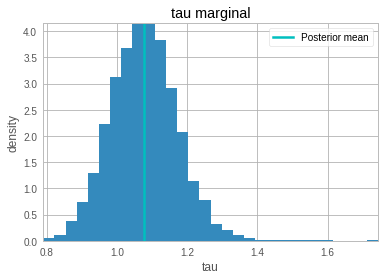

In [37]:
plot_marginal(tau_marginal, "tau")

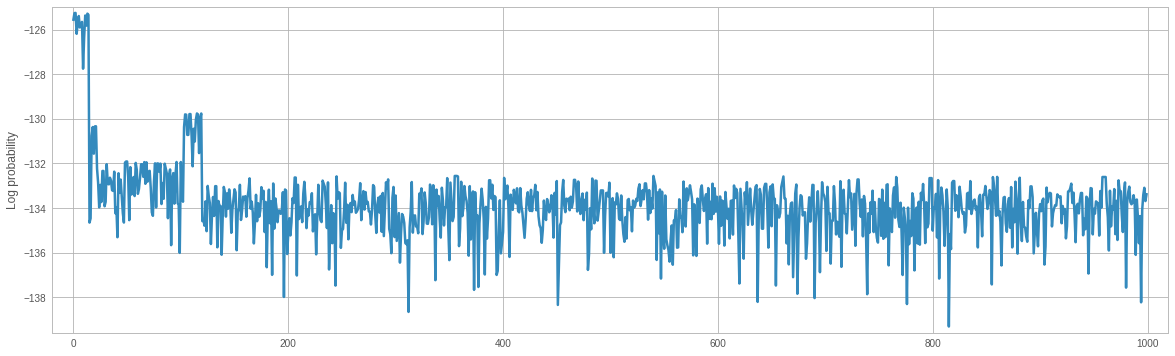

In [38]:
plot_log_prob(log_prob_test_results[:1000])